In [1]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(work_path)

from my_helper.regression import *
from my_helper.util import *
from my_helper.plot import *
from my_helper.analysis import *
from yjk_module.preprocessing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 읽기

In [3]:
origin = pd.read_csv("./data/Used_Car_Dataset.csv", index_col = 0)
df = origin.copy()

### EDA(1)

#### 상위 5개 데이터 샘플 및 크기

In [4]:
df.head()

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
0,2017 Mercedes-Benz S-Class S400,Jul-17,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,2996.0,333.0,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,Jan-21,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,999.0,9863.0,8.99
2,2018 BMW X1 sDrive 20d xLine,Sep-18,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,1995.0,188.0,23.75
3,2019 Kia Seltos GTX Plus,Dec-19,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,1353.0,13808.0,13.56
4,2019 Skoda Superb LK 1.8 TSI AT,Aug-19,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,1798.0,17746.0,24.00


In [5]:
df.shape

(1553, 14)

#### 데이터 타입

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1553 entries, 0 to 1552
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_name            1553 non-null   object 
 1   registration_year   1553 non-null   object 
 2   insurance_validity  1553 non-null   object 
 3   fuel_type           1553 non-null   object 
 4   seats               1553 non-null   int64  
 5   kms_driven          1553 non-null   int64  
 6   ownsership          1553 non-null   object 
 7   transmission        1553 non-null   object 
 8   manufacturing_year  1553 non-null   object 
 9   mileage(kmpl)       1550 non-null   float64
 10  engine(cc)          1550 non-null   float64
 11  max_power(bhp)      1550 non-null   float64
 12  torque(Nm)          1549 non-null   float64
 13  price(in lakhs)     1553 non-null   float64
dtypes: float64(5), int64(2), object(7)
memory usage: 182.0+ KB


#### 기술통계

In [7]:
df.describe()

,seats,kms_driven,mileage(kmpl),engine(cc),max_power(bhp),torque(Nm),price(in lakhs)
count,1553.000000,1553.000000,1550.000000,1.550000e+03,1.550000e+03,1.549000e+03,1553.000000
mean,91.480361,52841.931101,236.927277,1.471857e+10,1.471857e+10,1.423989e+04,166.141494
std,2403.424060,40067.800347,585.964295,2.185629e+11,2.185629e+11,9.666241e+04,3478.855090
min,4.000000,620.000000,7.810000,5.000000e+00,5.000000e+00,5.000000e+00,1.000000
25%,5.000000,30000.000000,16.342500,1.197000e+03,1.197000e+03,4.000000e+02,4.660000
50%,5.000000,49134.000000,18.900000,1.462000e+03,1.462000e+03,1.173000e+03,7.140000
75%,5.000000,70000.000000,22.000000,1.995000e+03,1.995000e+03,8.850000e+03,17.000000
max,67000.000000,810000.000000,3996.000000,3.258640e+12,3.258640e+12,1.464800e+06,95000.000000


In [8]:
df.describe(include = 'O')

,car_name,registration_year,insurance_validity,fuel_type,ownsership,transmission,manufacturing_year
count,1553,1553,1553,1553,1553,1553,1553
unique,925,178,6,4,22,13,19
top,2017 BMW X1 sDrive20d Expedition,2017,Comprehensive,Petrol,First Owner,Manual,2018
freq,25,40,1084,1013,1240,835,236


- 종속변수는 price(in lakhs)
- seats 열은 좌석 수로, 이산형 데이터이다. 수치형과 명목형 어느쪽으로든 분석할 수 있다.
- kms_driven, mileage, engine, max_power, torque는 연속형 데이터이다.
    - engine과 max_power의 경우 완전히 동일한 데이터로 한쪽은 삭제한다.
    - 수치형 데이터의 경우 상식적으로 판단하였을 때 이상치로 보이는 데이터가 존재한다 (좌석수 67000개)
        - 해당 데이터의 경우 별도의 정제가 필요하다
- car_name은 총 데이터 수 대비 종류수가 너무 많아 분석에 유의하지 않은 데이터일 확률이 높다
- registration_year, manufacturing_year의 수치형 데이터일 가능성이 높으나 명목형 데이터로 구분되었다.
  - 특정 데이터에 의하여 명목형 데이터가 되었을 가능성이 있다.
- 그외 명목형 데이터의 경우 데이터 종류 수가 많지 않아 분석에 충분히 활용이 가능할 것으로 보인다.

In [9]:
df.drop('max_power(bhp)', axis = 1, inplace = True)

#### 결측치 확인

In [10]:
df.isnull().sum()

car_name              0
registration_year     0
insurance_validity    0
fuel_type             0
seats                 0
kms_driven            0
ownsership            0
transmission          0
manufacturing_year    0
mileage(kmpl)         3
engine(cc)            3
torque(Nm)            4
price(in lakhs)       0
dtype: int64

- 결측치 갯수는 적기 때문에 제거

In [11]:
df.dropna(inplace = True)

#### 이상치 확인 (Boxplot)

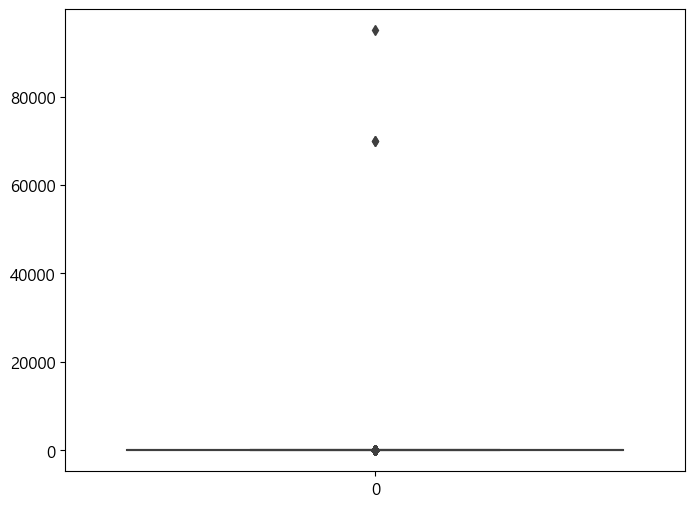

In [12]:
plt.figure()
sb.boxplot(data = df['price(in lakhs)'])
plt.show()

- 종속변수가 지나치게 큰 이상치가 2개 존재하는 것으로 보이며 해당 데이터는 삭제한다

In [13]:
df = df[df['price(in lakhs)'] < 10000]

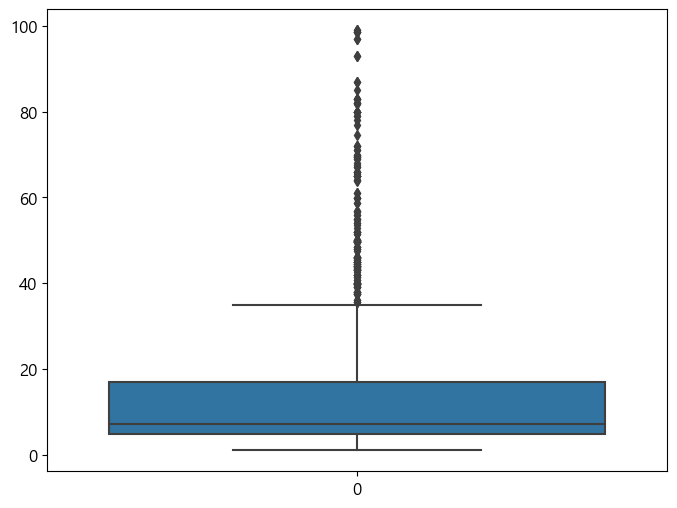

In [14]:
plt.figure()
sb.boxplot(data = df['price(in lakhs)'])
plt.show()

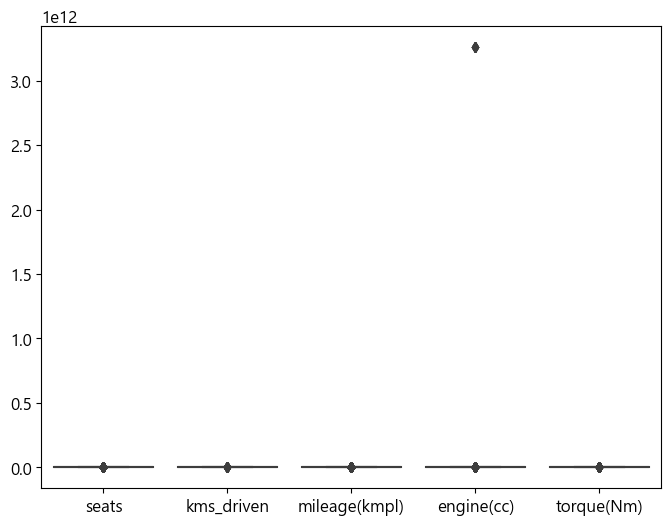

In [15]:
plt.figure()
sb.boxplot(data = df[['seats', 'kms_driven', 'mileage(kmpl)', 'engine(cc)', 'torque(Nm)']])
plt.show()

- 데이터 상세 확인 결과 데이터가 적합하지 않은 행에 들어가서 이상치로 감지되는 경우가 있는 것으로 추측된다.
    - ex) fuel_type에 seats가 들어가 있는 등
    - 해당 데이터는 올바른 위치로 데이터를 옮겨주는 전처리 작업이 요구됨

#### 데이터 전처리

- 잘못된 행에 기입된 데이터의 처리
    - 올바른 행에 데이터를 옮기더라도 남겨진 값은 결측치로 처리되기에 해당 데이터 수가 많지 않은 경우는 삭제 처리

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1546 entries, 0 to 1552
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   car_name            1546 non-null   object 
 1   registration_year   1546 non-null   object 
 2   insurance_validity  1546 non-null   object 
 3   fuel_type           1546 non-null   object 
 4   seats               1546 non-null   int64  
 5   kms_driven          1546 non-null   int64  
 6   ownsership          1546 non-null   object 
 7   transmission        1546 non-null   object 
 8   manufacturing_year  1546 non-null   object 
 9   mileage(kmpl)       1546 non-null   float64
 10  engine(cc)          1546 non-null   float64
 11  torque(Nm)          1546 non-null   float64
 12  price(in lakhs)     1546 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 201.4+ KB


In [17]:
df['registration_year'].unique()

array(['Jul-17', 'Jan-21', 'Sep-18', 'Dec-19', 'Aug-19', 'Feb-19',
       'Jul-18', 'Apr-15', 'Mar-19', 'Mar-20', 'Feb-22', '2014', 'Jan-22',
       'Apr-19', 'Aug-22', 'Mar-18', 'Nov-19', 'Nov-20', 'Sep-21',
       'Oct-10', 'Sep-15', 'Aug-11', 'Dec-15', 'Aug-17', 'Aug-20', '2018',
       'Oct-19', 'Dec-22', 'Jun-18', '2017', 'Jun-17', 'May-10', 'Mar-23',
       'Nov-15', 'Sep-20', 'Jul-21', 'Aug-18', 'Jun-20', 'Apr-21',
       'Nov-23', 'Dec-20', 'Jun-21', 'May-11', '2016', 'Oct-17', 'Nov-14',
       'Feb-18', '2009', 'Jul-16', 'Aug-21', 'Nov-18', 'Oct-18', 'Mar-17',
       'May-19', 'May-13', 'May-23', 'Jul-14', '2015', 'Sep-16', 'May-22',
       'Aug-15', 'Mar-21', 'Mar-22', 'Oct-20', 'Apr-16', 'Sep-23',
       'Dec-21', 'Nov-21', 'Dec-14', 'Jul-22', 'Jun-23', 'Jul-19',
       'Dec-12', 'Dec-16', 'Jun-16', 'Sep-19', 'Jun-10', 'Oct-14',
       'Mar-16', 'Dec-18', 'Feb-20', 'Apr-20', 'Jan-11', 'Oct-15',
       'Jan-19', '2023', 'Jul-13', 'May-21', 'Aug-13', 'Oct-13', 'Nov-17',
      

- Registration_year의 Third Party insurance (insurance_validity행 추정) 삭제

In [18]:
df = df[df['registration_year'] != 'Third Party insurance']

In [19]:
df['ownsership'].unique()

array(['First Owner', 'Second Owner', 'Third Owner', '2993 cc', '1461 cc',
       '998 cc', '1995 cc', '1451 cc', '1998 cc', '1498 cc', '1497 cc',
       '1996 cc', '1950 cc', 'Fifth Owner', '1199 cc', '1248 cc',
       '999 cc', '1197 cc', '1984 cc', '2999 cc', '1968 cc'], dtype=object)

In [20]:
df['ownsership'].value_counts()

First Owner     1236
Second Owner     238
1995 cc           24
Third Owner       20
1498 cc            3
999 cc             2
Fifth Owner        2
1497 cc            2
1451 cc            2
998 cc             2
1461 cc            2
2993 cc            2
1998 cc            1
1996 cc            1
1950 cc            1
1199 cc            1
1248 cc            1
1197 cc            1
1984 cc            1
2999 cc            1
1968 cc            1
Name: ownsership, dtype: int64

- ownsership의 경우 cc가 포함된 데이터는 engine(cc)데이터로 추정되어 해당 값으로 이전한다. ownsership 행에서는 최빈값인 First Owner로 값을 대체한다

In [21]:
cond = df[df['ownsership'].str.contains('cc')]
cond.head()

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage(kmpl),engine(cc),torque(Nm),price(in lakhs)
116,2017 BMW 7 Series 730Ld M Sport,2017,Third Party insurance,Diesel,5,60000,2993 cc,2017,Power Steering,2993.0,26149.0,620.0,55.0
136,2017 BMW 7 Series 730Ld M Sport,2017,Third Party insurance,Diesel,5,60000,2993 cc,2017,Power Steering,2993.0,26149.0,620.0,55.0
170,2014 Nissan Terrano XV 110 PS Limited Edition,2014,Third Party insurance,Diesel,5,100000,1461 cc,2014,Power Steering,1461.0,1085.0,248.0,6.0
190,2014 Nissan Terrano XV 110 PS Limited Edition,2014,Third Party insurance,Diesel,5,100000,1461 cc,2014,Power Steering,1461.0,1085.0,248.0,6.0
210,2023 Hyundai i20 N-Line N8 DCT BSVI,2023,Third Party insurance,Petrol,5,10000,998 cc,2023,Power Steering,998.0,11841.0,172.0,11.7


In [22]:
df.loc[cond.index, 'engine(cc)'] = cond['ownsership'].apply(lambda x : int(x[:-2].strip()))
df.loc[cond.index, 'ownsership'] = 'First Owner'

In [23]:
df['transmission'].value_counts()

Manual       829
Automatic    667
2017          28
2014           5
2011           3
2023           2
2020           2
2021           2
2022           2
2018           2
2015           1
2016           1
Name: transmission, dtype: int64

- transmission의 경우 특정 연도가 적혀있는 데이터가 있으며 이는 최빈값인 Manual로 대체한다

In [24]:
cond = df[df['transmission'].str.contains('20')]
df.loc[cond.index, 'transmission'] = 'Manual'

In [25]:
df['manufacturing_year'].value_counts()

2018                   236
2017                   190
2019                   184
2015                   133
2016                   133
2020                   122
2021                   119
2014                   103
2022                    89
2013                    51
2012                    50
Power Steering          46
2023                    35
2011                    22
2010                    18
2009                    10
Power Windows Front      2
2007                     1
Name: manufacturing_year, dtype: int64

- manufacturing_year의 경우 Power가 포함된 문자열 데이터를 대체해야 하지만 하나의 특정 값으로 대체하기는 어려워 registration_year 열의 값으로 대체함

In [26]:
cond = df[df['manufacturing_year'].str.contains('Power')]
df.loc[cond.index, 'manufacturing_year'] = cond['registration_year']

In [27]:
df['manufacturing_year'] = df['manufacturing_year'].astype('int')

- 데이터 전처리 : 데이터 형변환
    - registration_year에는 월까지 포함한 데이터가 있으며 해당 월을 제거하고 년도로 데이터를 통일

In [28]:
cond = df[df['registration_year'].str.contains('-')]
df.loc[cond.index, 'registration_year'] = cond['registration_year'].apply(lambda x : int(x[-2:]) + 2000)

In [29]:
df['registration_year'] = df['registration_year'].astype('int')

- 데이터 전처리 : 이상치 제거
    - engine의 이상치는 삭제
    - 이후 Boxplot 재확인

In [30]:
df = df[df['engine(cc)'] < 10000]

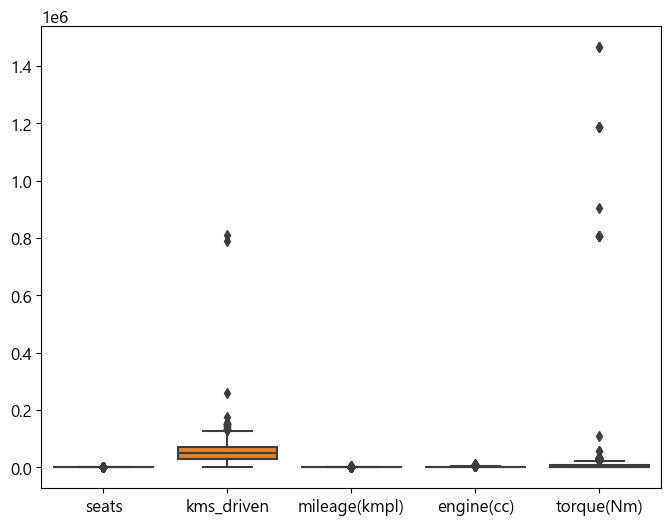

In [31]:
plt.figure()
sb.boxplot(data = df[['seats', 'kms_driven', 'mileage(kmpl)', 'engine(cc)', 'torque(Nm)']])
plt.show()

- kms_driven 250,000 이상, torque 30,000, mileage 100 이상인 데이터 삭제
    - seats는 명목형 데이터로 간주하여 추가적인 이상치 처리에서 제외
    - 처리후 Boxplot 재확인

In [32]:
df['seats'] = df['seats'].astype('category')

In [33]:
rename_dict = {'mileage(kmpl)' : 'mileage',
               'engine(cc)' : 'engine',
               'torque(Nm)' : 'torque',
               'price(in lakhs)' : 'price'}
df.rename(columns = rename_dict, inplace = True)

In [34]:
df = df.query('kms_driven < 250000 and torque < 30000 and mileage < 100')

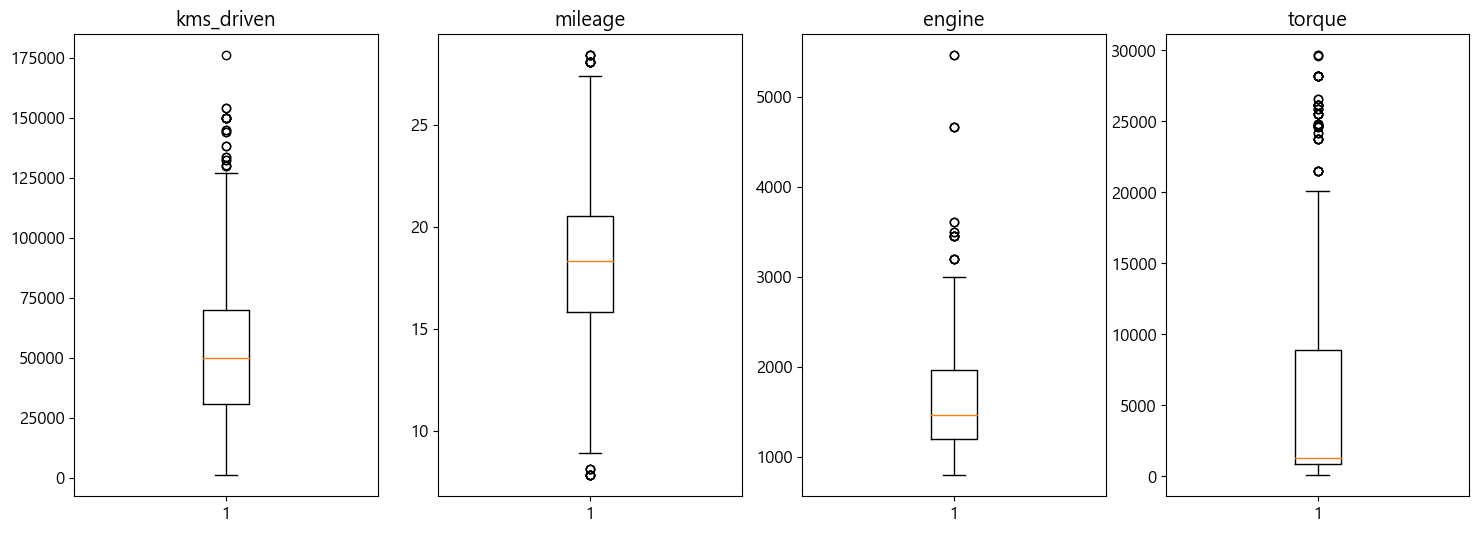

In [35]:
cols = ['kms_driven', 'mileage', 'engine', 'torque']

fig, ax = plt.subplots(1, 4, figsize = (18, 6))
for i, v in enumerate(cols):
    ax[i].boxplot(x = df[v])
    ax[i].set_title(v)
plt.show()

#### 중복데이터 제거
- 모든 내용이 일치하는 중복데이터 제거

In [36]:
df.drop_duplicates(inplace = True)

In [37]:
df.reset_index(inplace = True, drop = True)
df.head()

,car_name,registration_year,insurance_validity,fuel_type,seats,kms_driven,ownsership,transmission,manufacturing_year,mileage,engine,torque,price
0,2017 Mercedes-Benz S-Class S400,2017,Comprehensive,Petrol,5,56000,First Owner,Automatic,2017,7.81,2996.0,333.0,63.75
1,2020 Nissan Magnite Turbo CVT XV Premium Opt BSVI,2021,Comprehensive,Petrol,5,30615,First Owner,Automatic,2020,17.40,999.0,9863.0,8.99
2,2018 BMW X1 sDrive 20d xLine,2018,Comprehensive,Diesel,5,24000,First Owner,Automatic,2018,20.68,1995.0,188.0,23.75
3,2019 Kia Seltos GTX Plus,2019,Comprehensive,Petrol,5,18378,First Owner,Manual,2019,16.50,1353.0,13808.0,13.56
4,2019 Skoda Superb LK 1.8 TSI AT,2019,Comprehensive,Petrol,5,44900,First Owner,Automatic,2019,14.67,1798.0,17746.0,24.00


### EDA(2)
- 정제한 데이터를 기반으로 특징 재확인

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   car_name            942 non-null    object  
 1   registration_year   942 non-null    int32   
 2   insurance_validity  942 non-null    object  
 3   fuel_type           942 non-null    object  
 4   seats               942 non-null    category
 5   kms_driven          942 non-null    int64   
 6   ownsership          942 non-null    object  
 7   transmission        942 non-null    object  
 8   manufacturing_year  942 non-null    int32   
 9   mileage             942 non-null    float64 
 10  engine              942 non-null    float64 
 11  torque              942 non-null    float64 
 12  price               942 non-null    float64 
dtypes: category(1), float64(4), int32(2), int64(1), object(5)
memory usage: 82.2+ KB


In [39]:
df.describe()

,registration_year,kms_driven,manufacturing_year,mileage,engine,torque,price
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,2017.484076,52821.019108,2017.404459,18.378822,1572.295117,5891.684713,13.568875
std,2.828664,28856.243246,2.795339,3.683712,563.939138,6661.737754,16.000396
min,2007.000000,1000.000000,2007.000000,7.810000,796.000000,67.000000,1.000000
25%,2016.000000,31030.000000,2016.000000,16.125000,1197.000000,858.000000,4.950000
50%,2018.000000,50000.000000,2018.000000,18.600000,1423.500000,1661.000000,6.950000
75%,2019.000000,70000.000000,2019.000000,20.700000,1950.000000,8873.000000,14.185000
max,2023.000000,176000.000000,2023.000000,28.400000,5461.000000,29636.000000,98.500000


In [40]:
df.describe(include = ['object', 'category'])

,car_name,insurance_validity,fuel_type,seats,ownsership,transmission
count,942,942,942,942,942,942
unique,770,5,3,5,4,2
top,2014 Hyundai Grand i10 Sportz,Comprehensive,Petrol,5,First Owner,Manual
freq,6,679,617,833,785,535


- 'car_name' 열은 자동차 모델명이며 데이터 종류 수가 매우 많아 분석에 무의미하다고 판단되어 제거
  - 해당 명칭을 기반으로 차량의 제원 데이터를 외부로부터 가져와 분석에 활용할 수 있으나 고려하지 않음

In [41]:
df.drop('car_name', axis = 1, inplace = True)

In [42]:
df.isnull().sum()

registration_year     0
insurance_validity    0
fuel_type             0
seats                 0
kms_driven            0
ownsership            0
transmission          0
manufacturing_year    0
mileage               0
engine                0
torque                0
price                 0
dtype: int64

#### 산점도 행렬

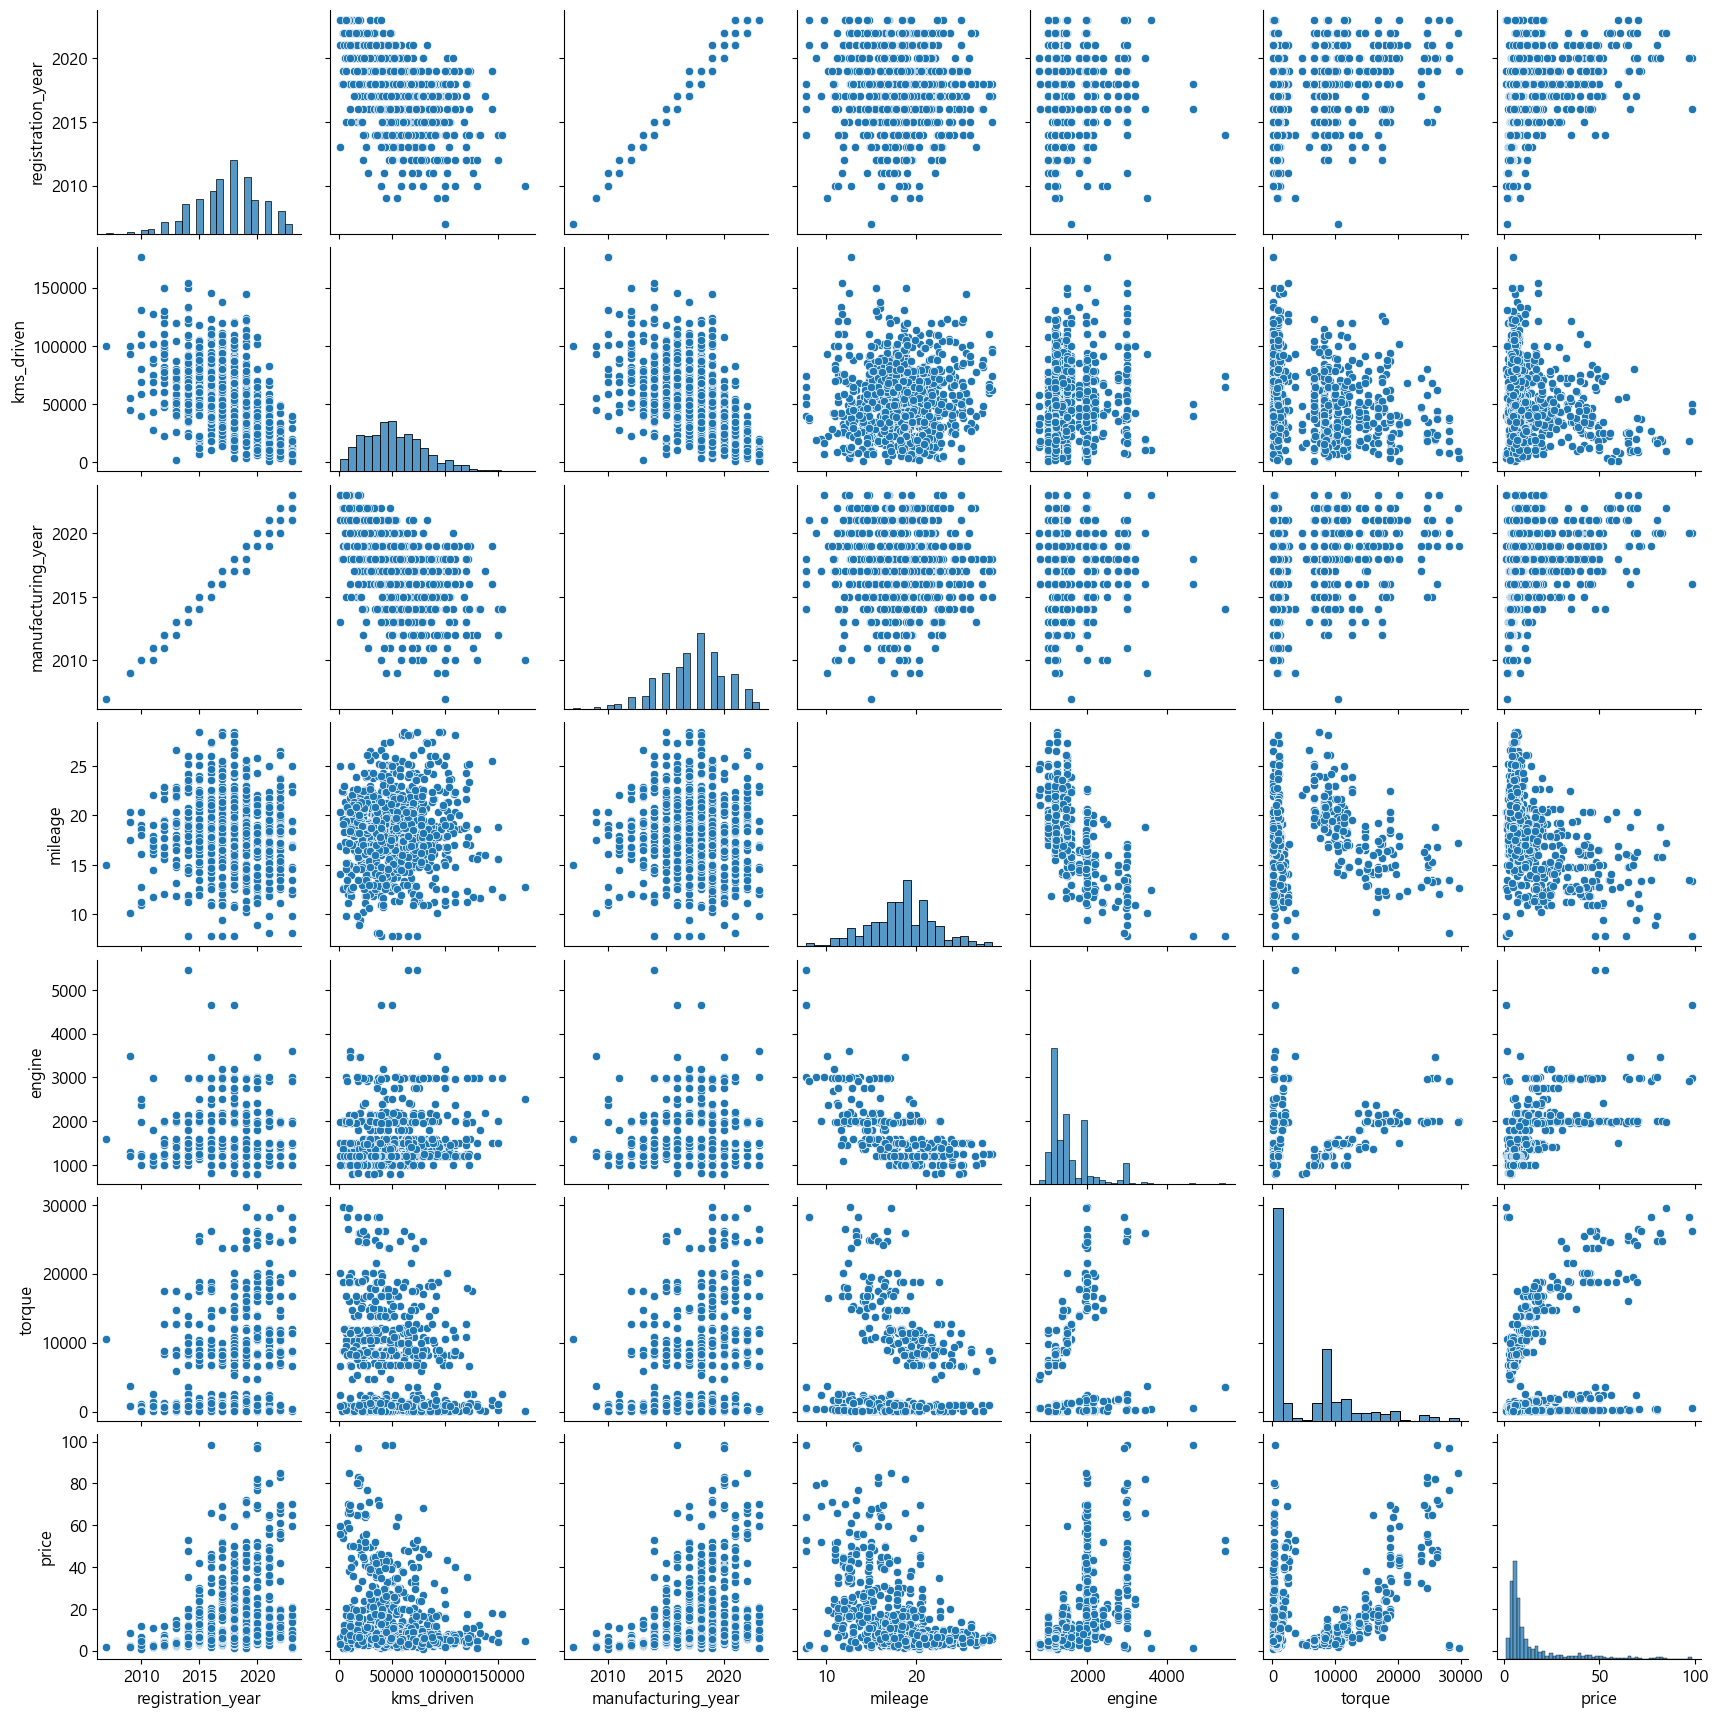

In [43]:
sb.pairplot(df)
plt.show()

- 일부 독립변수와 종속변수는 상관관계를 가지고 있음
  - 독립변수끼리 강한 상관관계를 가지고 있는 경우도 있어 다중공선성 방지를 위해 일부 열을 제거할 필요성이 있음

#### 종속변수 분포 확인
- 데이터는 1094개로, 히스토그램 구간 수는 11~13개로 설정 (12개)

In [44]:
X = df.copy()
Y = X.pop('price')

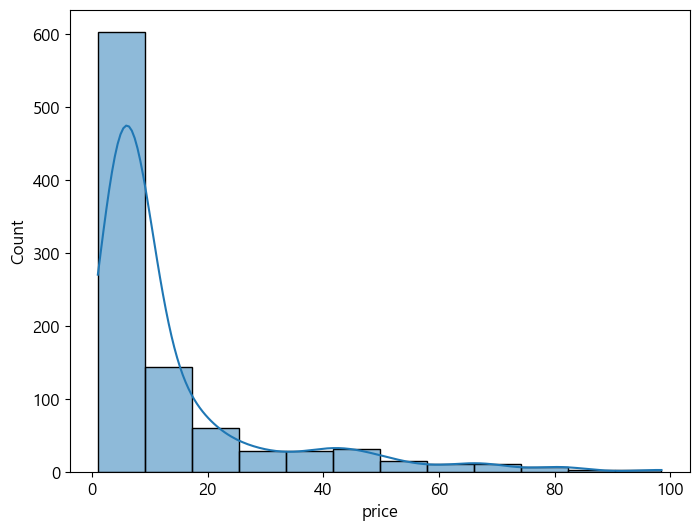

In [45]:
plt.figure()
sb.histplot(data = Y, kde = True, bins = 12)
plt.show()

- 종속변수 분포는 정규분포를 따르지 않는 것으로 보임

#### 연속형 독립변수 분포 확인

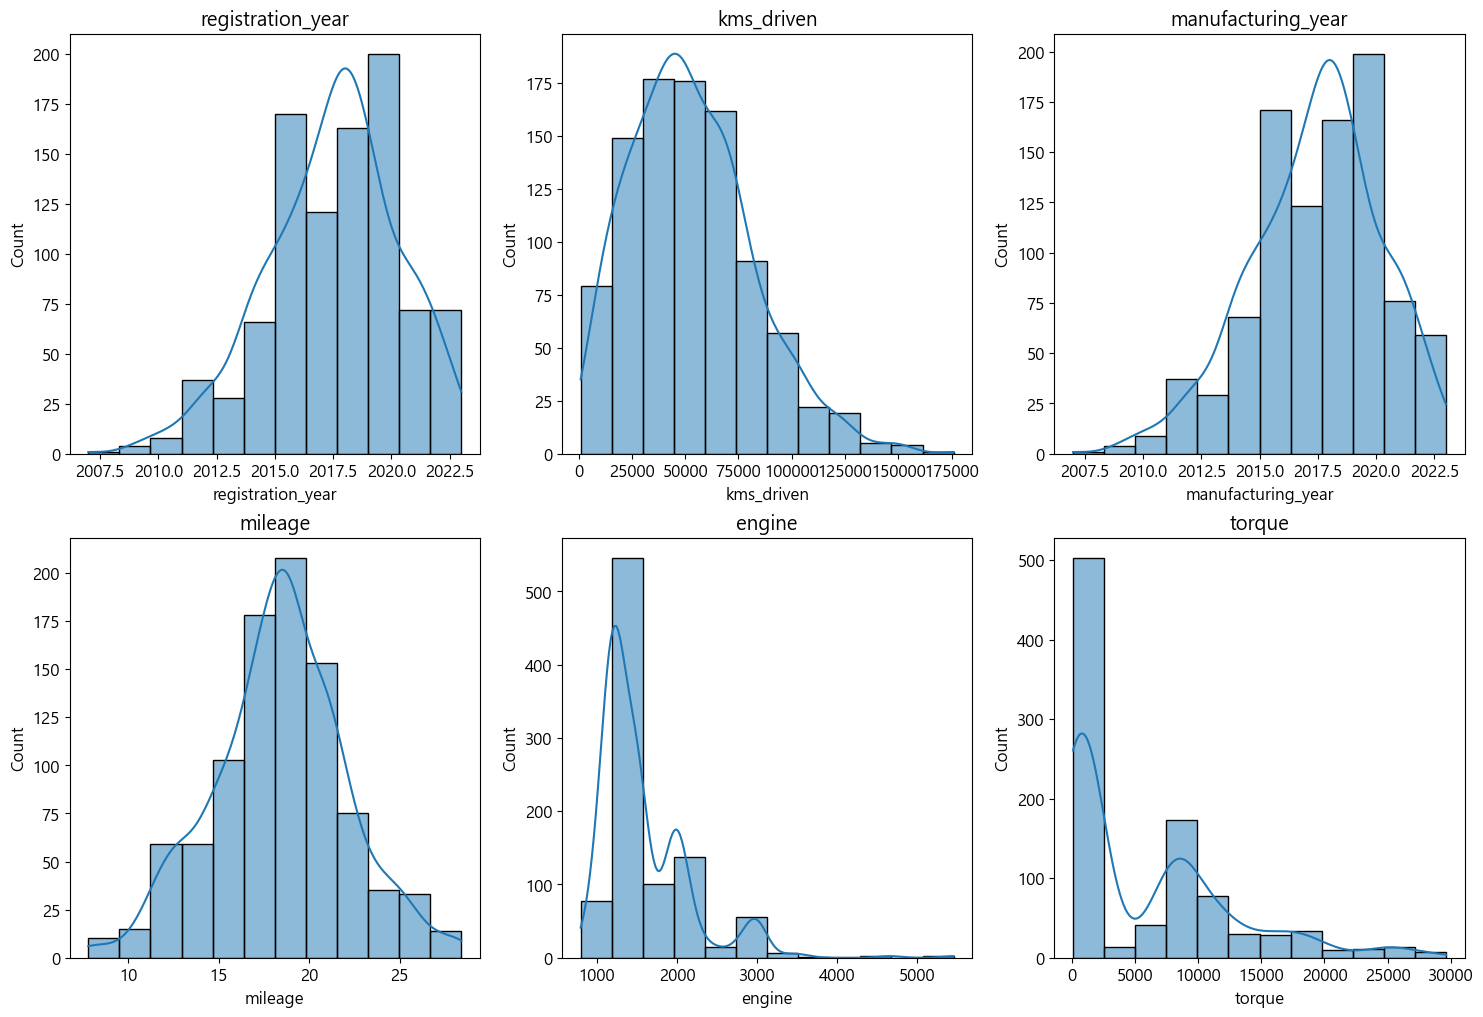

In [46]:
fig, ax = plt.subplots(2, 3, figsize = (18, 12))
ax = ax.flatten()
tmp = X.select_dtypes('number')

for i, v in enumerate(tmp.columns):
    sb.histplot(data = X[v], bins = 12, ax = ax[i], kde = True)
    ax[i].set_title(v)
plt.show()

#### 분산분석

In [47]:
col_o = X.select_dtypes(['object', 'category']).columns

In [48]:
for c in col_o:
    tmp = df[[c, 'price']]
    my_anova(tmp, hue=c, target='price')

pingouin.anova
+----+--------------------+--------+------+---------+--------+------------+-----------+
|    | Source             |     SS |   DF |      MS |      F |      p-unc |       np2 |
|----+--------------------+--------+------+---------+--------+------------+-----------|
|  0 | insurance_validity | 3977.1 |    4 | 994.275 | 3.9321 | 0.00358262 | 0.0165088 |
|  1 | Within             | 236931 |  937 | 252.861 |    nan |        nan |       nan |
+----+--------------------+--------+------+---------+--------+------------+-----------+

statsmodels.anova.anova_lm
+-----------------------+------+----------+-----------+--------+------------+
|                       |   df |   sum_sq |   mean_sq |      F |     PR(>F) |
|-----------------------+------+----------+-----------+--------+------------|
| C(insurance_validity) |    4 |   3977.1 |   994.275 | 3.9321 | 0.00358262 |
| Residual              |  937 |   236931 |   252.861 |    nan |        nan |
+-----------------------+------+-------

#### 명목형 데이터 / 종속변수 상관관계에 대한 시각화

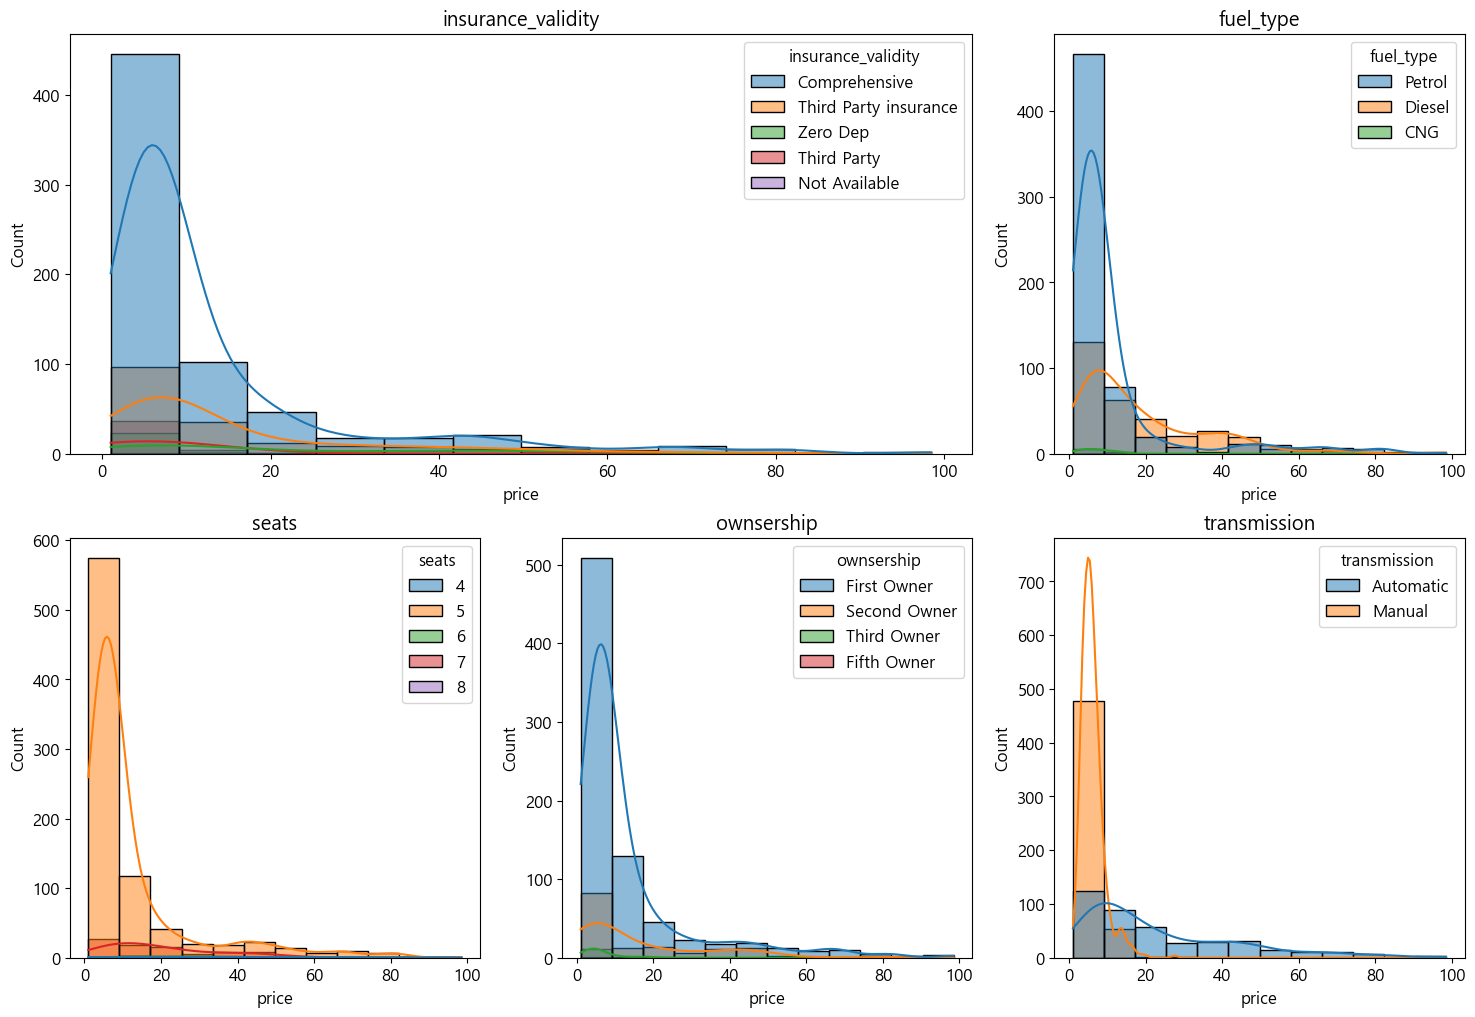

In [49]:
fig = plt.figure(figsize = (18, 12))
gs = GridSpec(2, 3)
ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
axs = [ax0, ax1, ax2, ax3, ax4]

for i, v in enumerate(col_o):
    sb.histplot(data = df, x = 'price', hue = v, bins = 12, ax = axs[i], kde = True)
    axs[i].set_title(v)

plt.show()

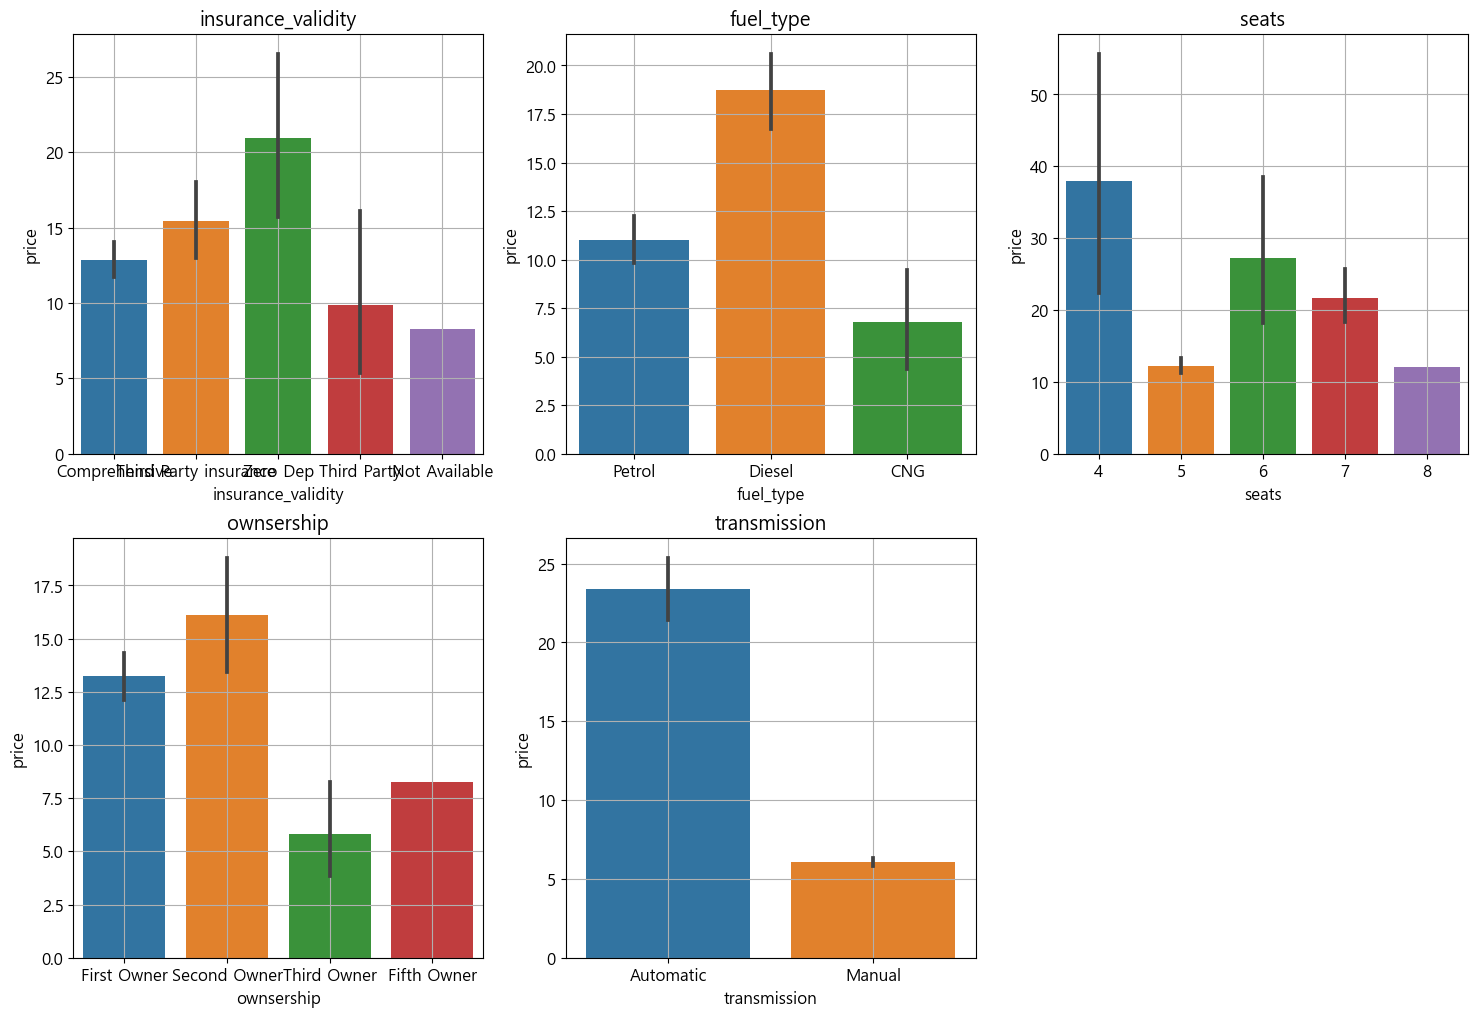

In [50]:
fig, ax = plt.subplots(2, 3, figsize = (18, 12))
ax = ax.flatten()

for i, v in enumerate(col_o):
    sb.barplot(data = df, x = v, y = 'price', ax = ax[i])
    ax[i].set_title(v)
    ax[i].grid()
ax[5].set_visible(False)
plt.show()

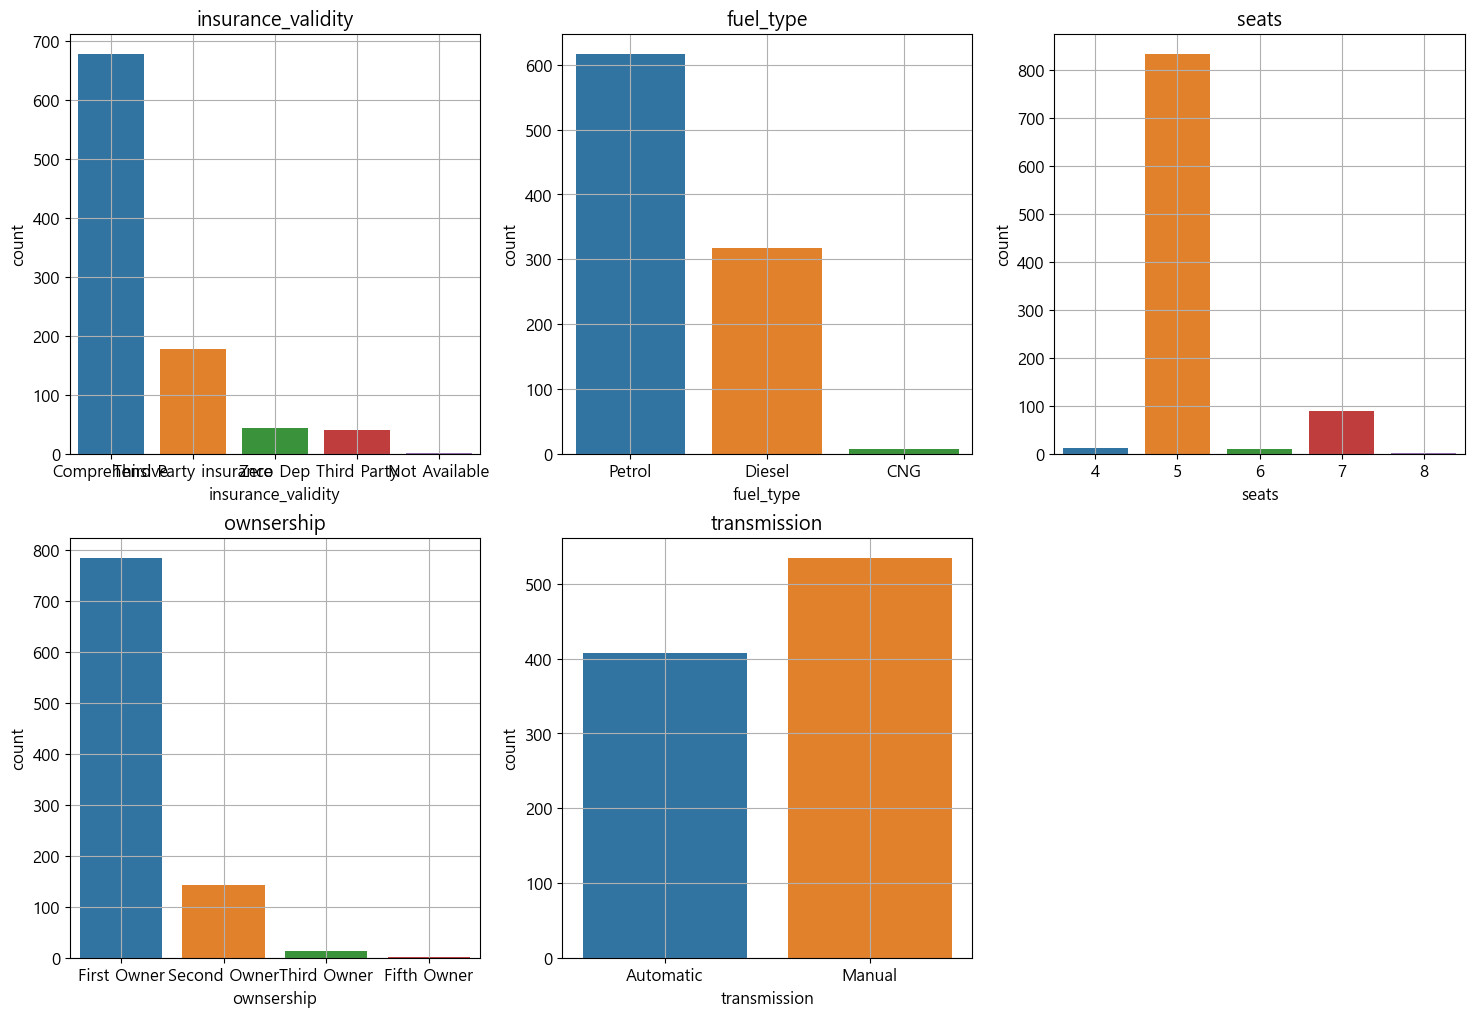

In [51]:
fig, ax = plt.subplots(2, 3, figsize = (18, 12))
ax = ax.flatten()

for i, v in enumerate(col_o):
    sb.countplot(data = df, x = v, ax = ax[i])
    ax[i].set_title(v)
    ax[i].grid()
ax[5].set_visible(False)
plt.show()

- transmission 열은 종속변수 예측에 매우 유의미한 변수가 될 것으로 예상됨

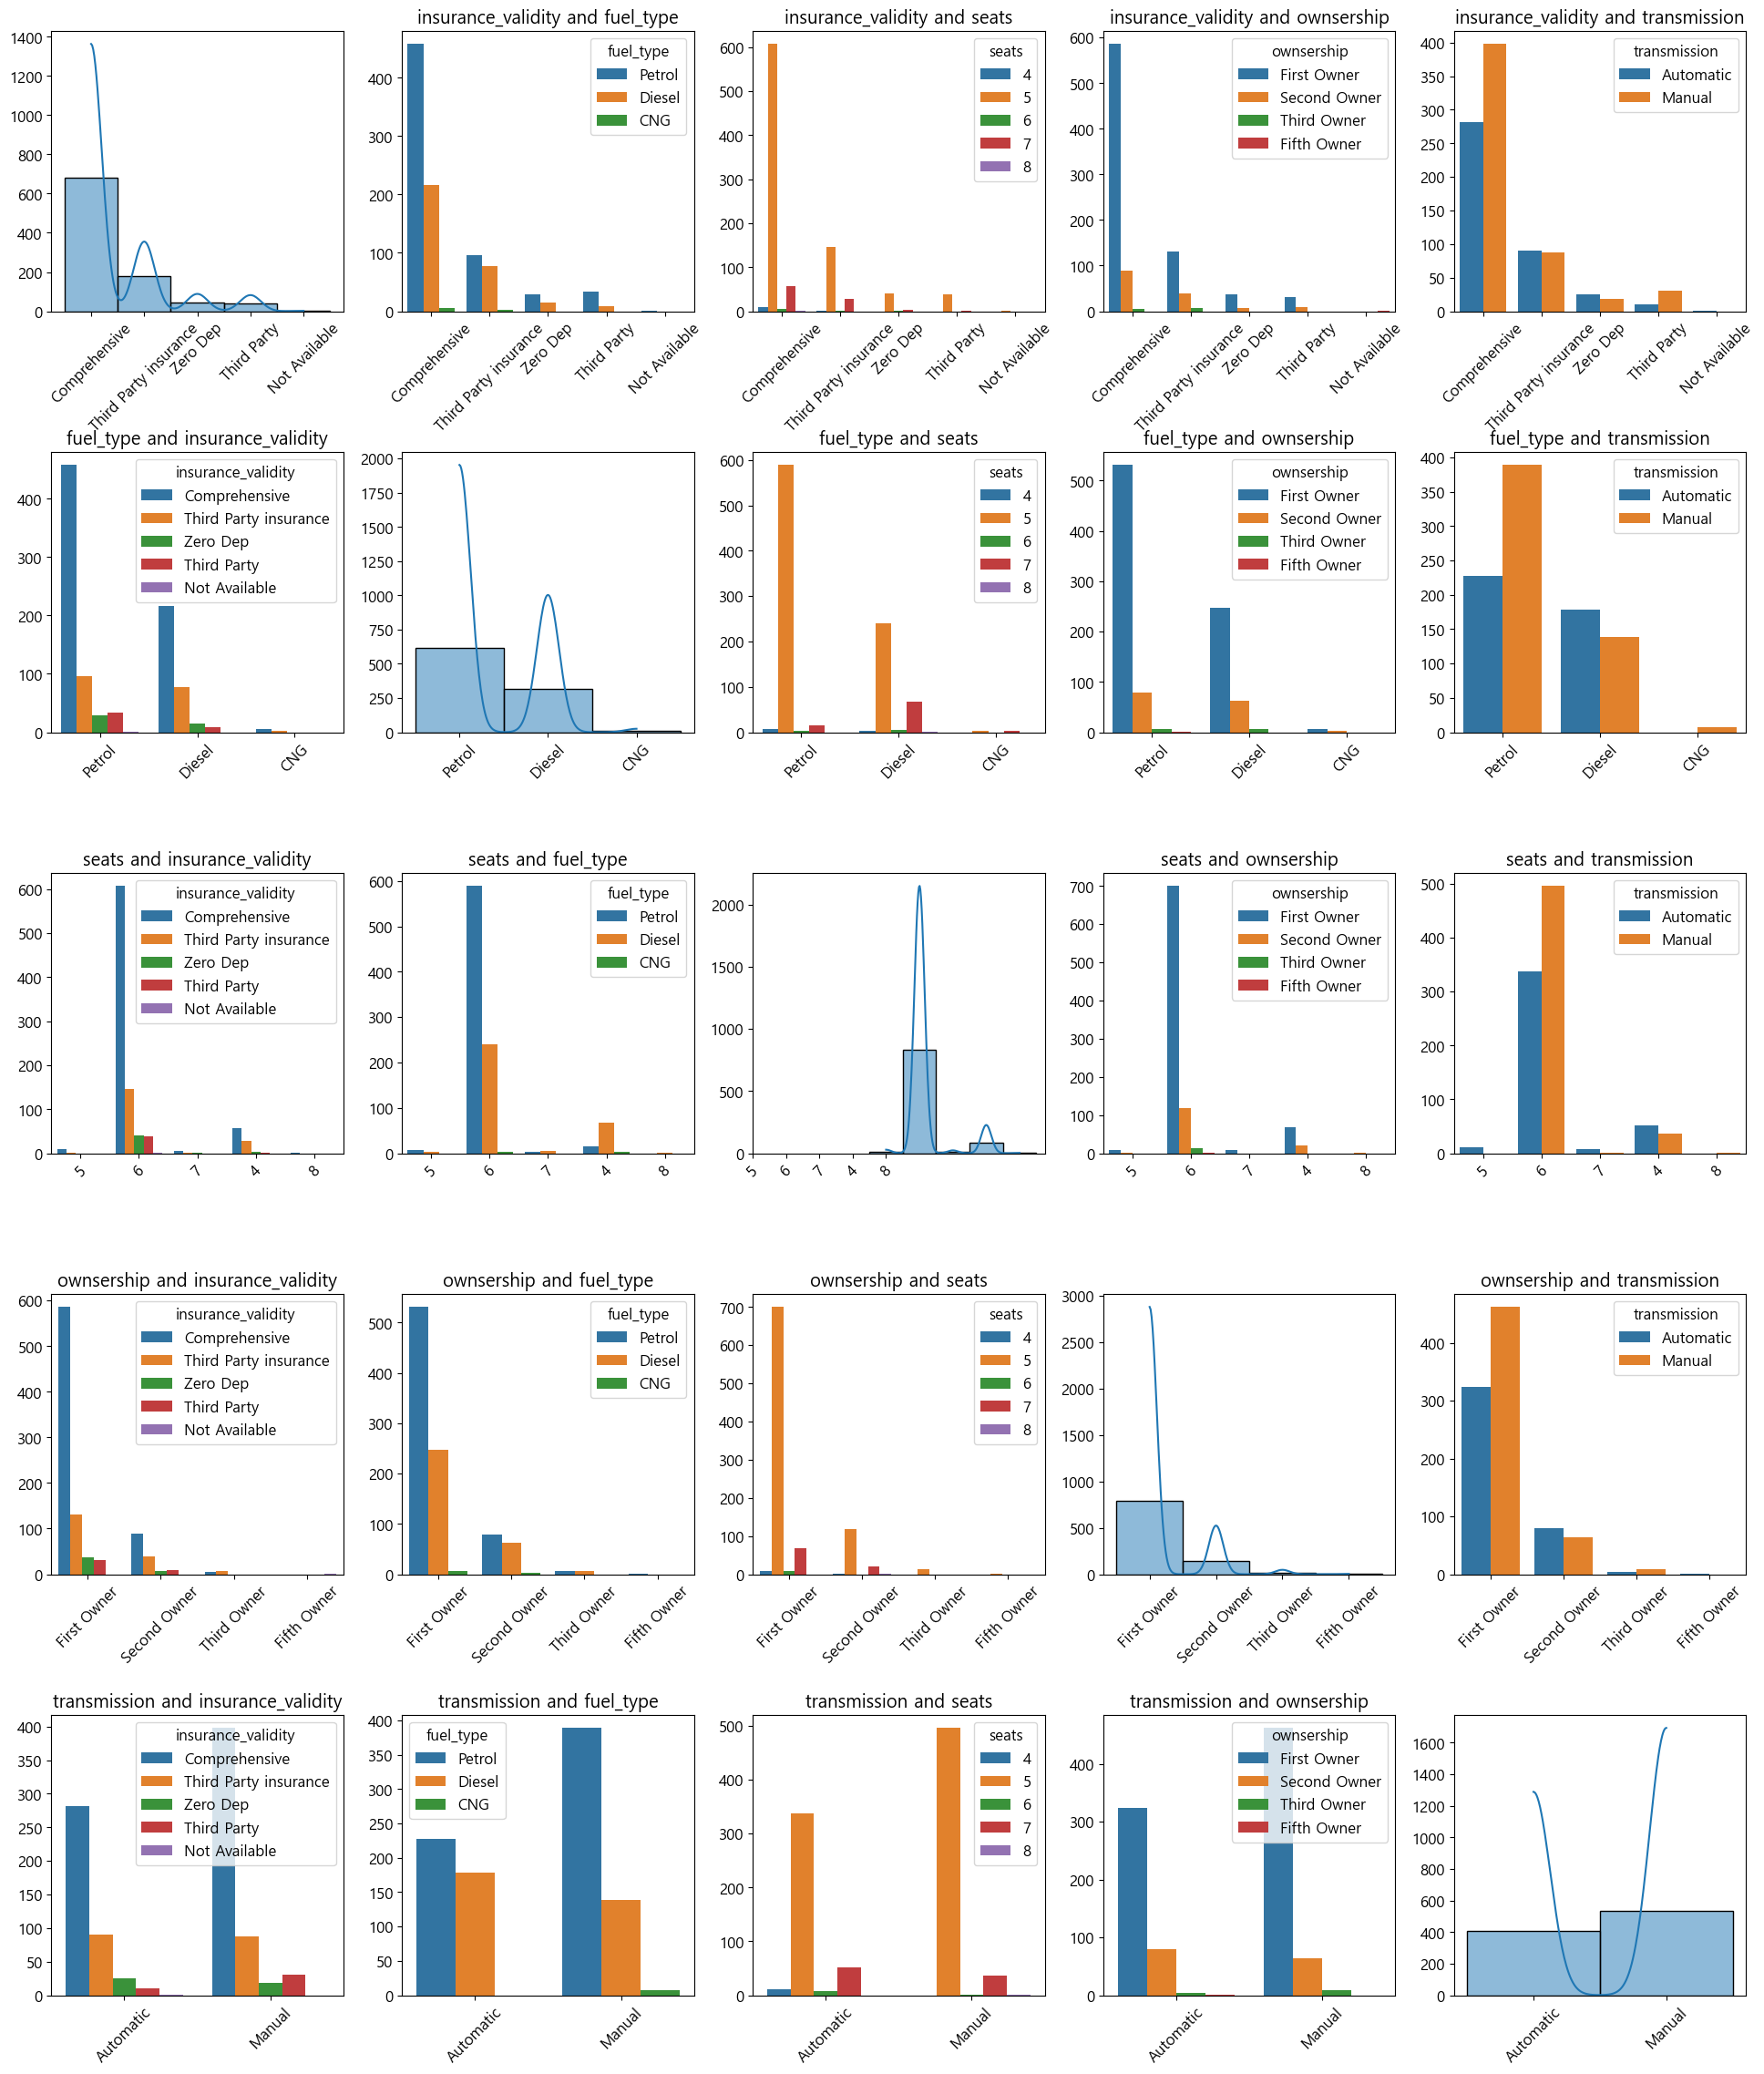

In [52]:
fig, ax = plt.subplots(len(col_o), len(col_o), figsize = (24, 28))
fig.subplots_adjust(hspace = 0.5)

for i, v in enumerate(col_o):
    for j, w in enumerate(col_o):
        if i == j:
            sb.histplot(data = df, x = v, ax = ax[i, j], kde = True, bins = 12)
            ax[i, j].set_xticks(range(0, len(df[v].unique())), df[v].unique(), rotation = 45)
            ax[i, j].set_xlabel("")
            ax[i, j].set_ylabel("")
        else:
            sb.countplot(data = df, x = v, hue = w, ax = ax[i, j])
            ax[i, j].set_title(f"{v} and {w}")
            ax[i, j].set_xticks(range(0, len(df[v].unique())), df[v].unique(), rotation = 45)
            ax[i, j].set_xlabel("")
            ax[i, j].set_ylabel("")

plt.show()

#### 상관계수 시각화

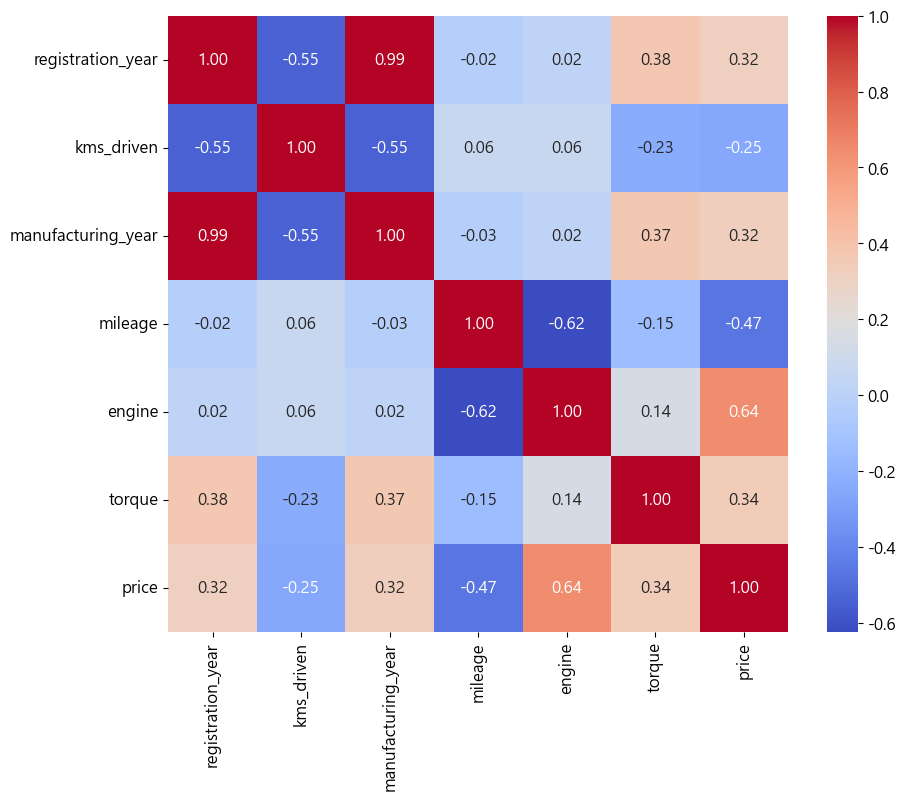

+---------------------------------------------+---------------+--------------+----------+
|                                             |   correlation |      p-value | result   |
|---------------------------------------------+---------------+--------------+----------|
| ('registration_year', 'kms_driven')         |     -0.546776 |  1.49376e-74 | True     |
| ('registration_year', 'manufacturing_year') |      0.994491 |            0 | True     |
| ('registration_year', 'mileage')            |    -0.0245842 |      0.45106 | False    |
| ('registration_year', 'engine')             |     0.0192851 |     0.554408 | False    |
| ('registration_year', 'torque')             |      0.376471 |    4.365e-33 | True     |
| ('registration_year', 'price')              |      0.319956 |  7.27025e-24 | True     |
| ('kms_driven', 'registration_year')         |     -0.546776 |  1.49376e-74 | True     |
| ('kms_driven', 'manufacturing_year')        |      -0.54704 |  1.23044e-74 | True     |
| ('kms_dr

In [53]:
my_correlation(data = df.select_dtypes('number'), dpi = 100)

- manufacturing_year과 registration_year는 매우 강한 상관관계를 보이고 있다
  - 그 외 독립변수 끼리도 상관관계가 어느정도 있음

### 선형 회귀 모델 생성

In [54]:
results = []

def add_result(model, note, x_test, y_test):
    global results
    tmp_dict = {}
    tmp_dict['How'] = note
    tmp_dict['R2_Score'] = model.score(x_test, y_test)
    tmp_dict['MAE'] = mean_absolute_error(y_test, model.predict(x_test))
    tmp_dict['RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    tmp_dict['model'] = model
    results.append(tmp_dict)

In [55]:
pp = YjkPreprocessor()
pp.set_strategy(outline = None, null = None)

아래와 같이 처리합니다.
+-------------+---------------+
| 범주        | 처리방법      |
|-------------+---------------|
| 이상치 처리 | 처리하지 않음 |
| 결측치 처리 | 처리하지 않음 |
| 스케일러    | 표준화        |
| 인코딩      | 원핫인코딩    |
+-------------+---------------+


In [56]:
X_p = pp.fit_transform(X)
X_p.head()

데이터프레임 크기 : (942, 11)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['registration_year', 'kms_driven', 'manufacturing_year', 'mileage', 'engine', 'torque'], 총 6개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'seats', 'ownsership', 'transmission'], 총 5개


,registration_year,kms_driven,manufacturing_year,mileage,engine,torque,insurance_validity_Comprehensive,insurance_validity_Not Available,insurance_validity_Third Party,insurance_validity_Third Party insurance,...,seats_5,seats_6,seats_7,seats_8,ownsership_Fifth Owner,ownsership_First Owner,ownsership_Second Owner,ownsership_Third Owner,transmission_Automatic,transmission_Manual
0,-0.171223,0.110225,-0.144767,-2.870592,2.525913,-0.834863,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.243623,-0.769948,0.929018,-0.265857,-1.017130,0.596455,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.182488,-0.999310,0.213161,0.625022,0.749956,-0.856641,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.536200,-1.194241,0.571089,-0.510306,-0.389070,1.188957,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.536200,-0.274645,0.571089,-1.007351,0.400442,1.780408,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [57]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)

In [58]:
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, '기본 데이터', x_test, y_test)

[회귀식]
price = -2.227 * registration_year + -2.545 * kms_driven + 3.958 * manufacturing_year + -0.620 * mileage + 8.186 * engine + 1.755 * torque + 1.139 * insurance_validity_Comprehensive + -11.753 * insurance_validity_Not Available + 2.333 * insurance_validity_Third Party + 1.595 * insurance_validity_Third Party insurance + 6.686 * insurance_validity_Zero Dep + 1.427 * fuel_type_CNG + -0.630 * fuel_type_Diesel + -0.797 * fuel_type_Petrol + 3.393 * seats_4 + 1.309 * seats_5 + 5.243 * seats_6 + -0.520 * seats_7 + -9.425 * seats_8 + -11.753 * ownsership_Fifth Owner + 3.403 * ownsership_First Owner + 4.714 * ownsership_Second Owner + 3.636 * ownsership_Third Owner + 2.939 * transmission_Automatic + -2.939 * transmission_Manual + 8.284

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제곱오차(MSE) |   평균오차(RMSE) |   평균 절대 백분오차 비율(MAPE) |  

### 데이터 전처리(2)

#### Torque Binning
- Torque가 일정 수치 이하일 경우 price가 낮게 형성되는 경향이 있음
  - 해당 기준으로 명목형 변수를 생성하여 분석모델에 추가

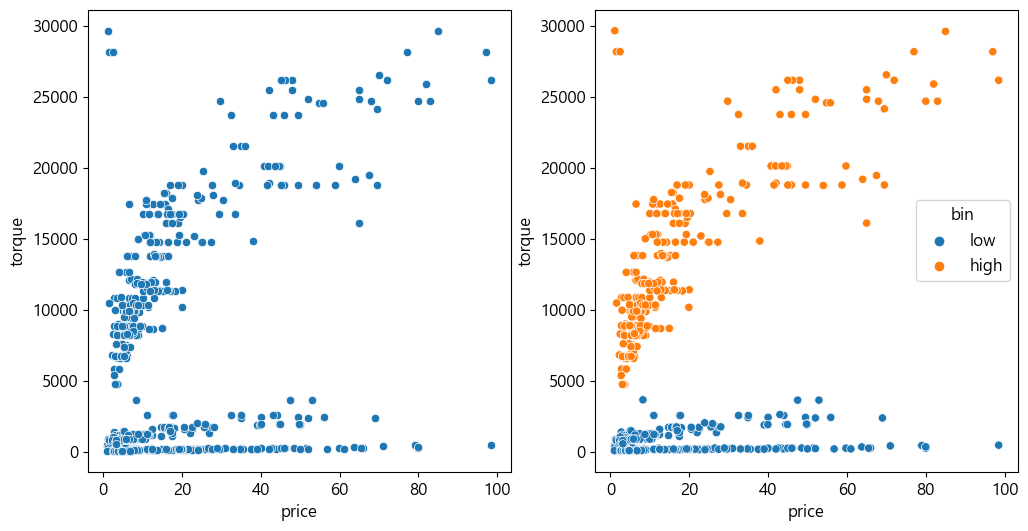

In [59]:
tor = df[['torque', 'price']]
tor['bin'] = tor['torque'].apply(lambda x : 'high' if x > 4500 else 'low')


fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sb.scatterplot(y = X['torque'], x = Y, ax = ax[0])
sb.scatterplot(data = tor, y = 'torque', x = 'price', hue = 'bin')
plt.show()

- torque 4500을 기준으로 분할
- 이후 회귀분석 실행

In [60]:
X['torque_bin'] = X['torque'].apply(lambda x : 'high' if x > 4500 else 'low')

In [61]:
X['torque_bin'].value_counts()

low     513
high    429
Name: torque_bin, dtype: int64

In [62]:
X_p = pp.fit_transform(X)
X_p.head()

데이터프레임 크기 : (942, 12)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['registration_year', 'kms_driven', 'manufacturing_year', 'mileage', 'engine', 'torque'], 총 6개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'seats', 'ownsership', 'transmission', 'torque_bin'], 총 6개


,registration_year,kms_driven,manufacturing_year,mileage,engine,torque,insurance_validity_Comprehensive,insurance_validity_Not Available,insurance_validity_Third Party,insurance_validity_Third Party insurance,...,seats_7,seats_8,ownsership_Fifth Owner,ownsership_First Owner,ownsership_Second Owner,ownsership_Third Owner,transmission_Automatic,transmission_Manual,torque_bin_high,torque_bin_low
0,-0.171223,0.110225,-0.144767,-2.870592,2.525913,-0.834863,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.243623,-0.769948,0.929018,-0.265857,-1.017130,0.596455,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.182488,-0.999310,0.213161,0.625022,0.749956,-0.856641,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.536200,-1.194241,0.571089,-0.510306,-0.389070,1.188957,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.536200,-0.274645,0.571089,-1.007351,0.400442,1.780408,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [63]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, 'Binning', x_test, y_test)

[회귀식]
price = -5.179 * registration_year + -2.470 * kms_driven + 7.382 * manufacturing_year + 0.413 * mileage + 7.494 * engine + 7.371 * torque + 0.810 * insurance_validity_Comprehensive + -10.915 * insurance_validity_Not Available + 2.727 * insurance_validity_Third Party + 1.129 * insurance_validity_Third Party insurance + 6.250 * insurance_validity_Zero Dep + 1.141 * fuel_type_CNG + -1.113 * fuel_type_Diesel + -0.028 * fuel_type_Petrol + 3.190 * seats_4 + 1.038 * seats_5 + 3.585 * seats_6 + -0.004 * seats_7 + -7.809 * seats_8 + -10.915 * ownsership_Fifth Owner + 3.194 * ownsership_First Owner + 5.065 * ownsership_Second Owner + 2.656 * ownsership_Third Owner + 2.484 * transmission_Automatic + -2.484 * transmission_Manual + -6.437 * torque_bin_high + 6.437 * torque_bin_low + 8.037

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결정계수(R2) |   평균절대오차(MAE) |   평균제

#### 명목형 변수 조합
- 교효작용이 있을 수 있는 fuel_type과 transmission을 결합한 새로운 명목형 변수 생성

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   registration_year   942 non-null    int32   
 1   insurance_validity  942 non-null    object  
 2   fuel_type           942 non-null    object  
 3   seats               942 non-null    category
 4   kms_driven          942 non-null    int64   
 5   ownsership          942 non-null    object  
 6   transmission        942 non-null    object  
 7   manufacturing_year  942 non-null    int32   
 8   mileage             942 non-null    float64 
 9   engine              942 non-null    float64 
 10  torque              942 non-null    float64 
 11  torque_bin          942 non-null    object  
dtypes: category(1), float64(3), int32(2), int64(1), object(5)
memory usage: 74.8+ KB


In [65]:
X['fuel_trans'] = X['fuel_type'] + "_" + X['transmission']

In [66]:
X['fuel_trans'].value_counts()

Petrol_Manual       389
Petrol_Automatic    228
Diesel_Automatic    179
Diesel_Manual       138
CNG_Manual            8
Name: fuel_trans, dtype: int64

In [67]:
X_p = pp.fit_transform(X)
X_p.head()

데이터프레임 크기 : (942, 13)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['registration_year', 'kms_driven', 'manufacturing_year', 'mileage', 'engine', 'torque'], 총 6개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'seats', 'ownsership', 'transmission', 'torque_bin', 'fuel_trans'], 총 7개


,registration_year,kms_driven,manufacturing_year,mileage,engine,torque,insurance_validity_Comprehensive,insurance_validity_Not Available,insurance_validity_Third Party,insurance_validity_Third Party insurance,...,ownsership_Third Owner,transmission_Automatic,transmission_Manual,torque_bin_high,torque_bin_low,fuel_trans_CNG_Manual,fuel_trans_Diesel_Automatic,fuel_trans_Diesel_Manual,fuel_trans_Petrol_Automatic,fuel_trans_Petrol_Manual
0,-0.171223,0.110225,-0.144767,-2.870592,2.525913,-0.834863,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.243623,-0.769948,0.929018,-0.265857,-1.017130,0.596455,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.182488,-0.999310,0.213161,0.625022,0.749956,-0.856641,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.536200,-1.194241,0.571089,-0.510306,-0.389070,1.188957,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.536200,-0.274645,0.571089,-1.007351,0.400442,1.780408,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [68]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, 'fuel_trans 추가', x_test, y_test)

[회귀식]
price = -5.407 * registration_year + -2.461 * kms_driven + 7.585 * manufacturing_year + 0.451 * mileage + 7.470 * engine + 7.402 * torque + -3265408935848.144 * insurance_validity_Comprehensive + 4084608885230.807 * insurance_validity_Not Available + -3265408935846.213 * insurance_validity_Third Party + -3265408935847.777 * insurance_validity_Third Party insurance + -3265408935842.710 * insurance_validity_Zero Dep + -16262984670609.078 * fuel_type_CNG + -471223653880.793 * fuel_type_Diesel + 4020889017209.679 * fuel_type_Petrol + -1119057588591.521 * seats_4 + -1119057588593.809 * seats_5 + -1119057588591.369 * seats_6 + -1119057588594.826 * seats_7 + -1119057588602.220 * seats_8 + -2725560572444.997 * ownsership_Fifth Owner + 4624457248659.557 * ownsership_First Owner + 4624457248661.388 * ownsership_Second Owner + 4624457248659.082 * ownsership_Third Owner + -32901141599358.762 * transmission_Automatic + 41133631884134.273 * transmission_Manual + -3070185134129.417 * torque_bin

- 2개의 명목형 변수를 조합한 파생변수가 추가되어 기존 명목형 변수를 제거할 경우 성능변화 확인

In [69]:
X_p = pp.fit_transform(X.drop(['fuel_type', 'transmission'], axis = 1))
X_p.head()

데이터프레임 크기 : (942, 11)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['registration_year', 'kms_driven', 'manufacturing_year', 'mileage', 'engine', 'torque'], 총 6개
명목형 데이터 컬럼 : ['insurance_validity', 'seats', 'ownsership', 'torque_bin', 'fuel_trans'], 총 5개


,registration_year,kms_driven,manufacturing_year,mileage,engine,torque,insurance_validity_Comprehensive,insurance_validity_Not Available,insurance_validity_Third Party,insurance_validity_Third Party insurance,...,ownsership_First Owner,ownsership_Second Owner,ownsership_Third Owner,torque_bin_high,torque_bin_low,fuel_trans_CNG_Manual,fuel_trans_Diesel_Automatic,fuel_trans_Diesel_Manual,fuel_trans_Petrol_Automatic,fuel_trans_Petrol_Manual
0,-0.171223,0.110225,-0.144767,-2.870592,2.525913,-0.834863,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.243623,-0.769948,0.929018,-0.265857,-1.017130,0.596455,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.182488,-0.999310,0.213161,0.625022,0.749956,-0.856641,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.536200,-1.194241,0.571089,-0.510306,-0.389070,1.188957,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.536200,-0.274645,0.571089,-1.007351,0.400442,1.780408,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, '명목형 변수 조합 원본 삭제', x_test, y_test)

[회귀식]
price = -5.217 * registration_year + -2.463 * kms_driven + 7.428 * manufacturing_year + 0.472 * mileage + 7.486 * engine + 7.403 * torque + 0.784 * insurance_validity_Comprehensive + -10.798 * insurance_validity_Not Available + 2.704 * insurance_validity_Third Party + 1.121 * insurance_validity_Third Party insurance + 6.190 * insurance_validity_Zero Dep + 3.187 * seats_4 + 0.927 * seats_5 + 3.393 * seats_6 + -0.079 * seats_7 + -7.427 * seats_8 + -10.798 * ownsership_Fifth Owner + 3.146 * ownsership_First Owner + 4.972 * ownsership_Second Owner + 2.680 * ownsership_Third Owner + -6.469 * torque_bin_high + 6.469 * torque_bin_low + -0.649 * fuel_trans_CNG_Manual + 2.411 * fuel_trans_Diesel_Automatic + -3.201 * fuel_trans_Diesel_Manual + 3.074 * fuel_trans_Petrol_Automatic + -1.635 * fuel_trans_Petrol_Manual + 7.447

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|       

#### 2차항 생성
- 연속형 변수에 대하여 2차항 생성

In [71]:
col_n = ['kms_driven', 'mileage', 'engine', 'torque']
pf = PolynomialFeatures(degree = 2, include_bias = False)

In [72]:
X_n = X[col_n]
X_o = X.drop(col_n, axis = 1)
X_n = pd.DataFrame(pf.fit_transform(X_n), columns = pf.get_feature_names_out())
poly_X = pd.concat([X_n, X_o], axis = 1)
poly_X.head()

,kms_driven,mileage,engine,torque,kms_driven^2,kms_driven mileage,kms_driven engine,kms_driven torque,mileage^2,mileage engine,...,torque^2,registration_year,insurance_validity,fuel_type,seats,ownsership,transmission,manufacturing_year,torque_bin,fuel_trans
0,56000.0,7.81,2996.0,333.0,3.136000e+09,437360.0,167776000.0,18648000.0,60.9961,23398.76,...,110889.0,2017,Comprehensive,Petrol,5,First Owner,Automatic,2017,low,Petrol_Automatic
1,30615.0,17.40,999.0,9863.0,9.372782e+08,532701.0,30584385.0,301955745.0,302.7600,17382.60,...,97278769.0,2021,Comprehensive,Petrol,5,First Owner,Automatic,2020,high,Petrol_Automatic
2,24000.0,20.68,1995.0,188.0,5.760000e+08,496320.0,47880000.0,4512000.0,427.6624,41256.60,...,35344.0,2018,Comprehensive,Diesel,5,First Owner,Automatic,2018,low,Diesel_Automatic
3,18378.0,16.50,1353.0,13808.0,3.377509e+08,303237.0,24865434.0,253763424.0,272.2500,22324.50,...,190660864.0,2019,Comprehensive,Petrol,5,First Owner,Manual,2019,high,Petrol_Manual
4,44900.0,14.67,1798.0,17746.0,2.016010e+09,658683.0,80730200.0,796795400.0,215.2089,26376.66,...,314920516.0,2019,Comprehensive,Petrol,5,First Owner,Automatic,2019,high,Petrol_Automatic


In [73]:
X_p = pp.fit_transform(poly_X)
X_p.head()

데이터프레임 크기 : (942, 23)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['kms_driven', 'mileage', 'engine', 'torque', 'kms_driven^2', 'kms_driven mileage', 'kms_driven engine', 'kms_driven torque', 'mileage^2', 'mileage engine', 'mileage torque', 'engine^2', 'engine torque', 'torque^2', 'registration_year', 'manufacturing_year'], 총 16개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'seats', 'ownsership', 'transmission', 'torque_bin', 'fuel_trans'], 총 7개


,kms_driven,mileage,engine,torque,kms_driven^2,kms_driven mileage,kms_driven engine,kms_driven torque,mileage^2,mileage engine,...,ownsership_Third Owner,transmission_Automatic,transmission_Manual,torque_bin_high,torque_bin_low,fuel_trans_CNG_Manual,fuel_trans_Diesel_Automatic,fuel_trans_Diesel_Manual,fuel_trans_Petrol_Automatic,fuel_trans_Petrol_Manual
0,0.110225,-2.870592,2.525913,-0.834863,-0.128334,-0.922578,1.378631,-0.702952,-2.131758,-0.627707,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.769948,-0.265857,-1.017130,0.596455,-0.709101,-0.759696,-0.881191,0.099887,-0.356661,-1.526192,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.999310,0.625022,0.749956,-0.856641,-0.804529,-0.821850,-0.596298,-0.743011,0.560406,2.039275,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.194241,-0.510306,-0.389070,1.188957,-0.867459,-1.151716,-0.975394,-0.036681,-0.580674,-0.788143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.274645,-1.007351,0.400442,1.780408,-0.424166,-0.544466,-0.055189,1.502166,-0.999486,-0.182972,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [74]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, '2차항 생성', x_test, y_test)

[회귀식]
price = -3.968 * kms_driven + -16.344 * mileage + 5.417 * engine + -14.312 * torque + 1.172 * kms_driven^2 + 4.272 * kms_driven mileage + -4.449 * kms_driven engine + 0.108 * kms_driven torque + 9.745 * mileage^2 + 3.997 * mileage engine + 15.233 * mileage torque + -0.212 * engine^2 + -7.786 * engine torque + 13.071 * torque^2 + -3.632 * registration_year + 5.543 * manufacturing_year + -0.059 * insurance_validity_Comprehensive + -5.323 * insurance_validity_Not Available + 1.452 * insurance_validity_Third Party + -0.545 * insurance_validity_Third Party insurance + 4.474 * insurance_validity_Zero Dep + -0.883 * fuel_type_CNG + -0.069 * fuel_type_Diesel + 0.952 * fuel_type_Petrol + -2.465 * seats_4 + -1.028 * seats_5 + 1.149 * seats_6 + -1.319 * seats_7 + 3.663 * seats_8 + -5.323 * ownsership_Fifth Owner + 1.590 * ownsership_First Owner + 3.381 * ownsership_Second Owner + 0.352 * ownsership_Third Owner + 1.580 * transmission_Automatic + -1.580 * transmission_Manual + -4.247 * torque

#### Seats 수치 데이터로 변형

In [75]:
poly_X['seats'] = poly_X['seats'].astype('int')

In [76]:
X_p = pp.fit_transform(poly_X)
X_p.head()

데이터프레임 크기 : (942, 23)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['kms_driven', 'mileage', 'engine', 'torque', 'kms_driven^2', 'kms_driven mileage', 'kms_driven engine', 'kms_driven torque', 'mileage^2', 'mileage engine', 'mileage torque', 'engine^2', 'engine torque', 'torque^2', 'registration_year', 'seats', 'manufacturing_year'], 총 17개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'ownsership', 'transmission', 'torque_bin', 'fuel_trans'], 총 6개


,kms_driven,mileage,engine,torque,kms_driven^2,kms_driven mileage,kms_driven engine,kms_driven torque,mileage^2,mileage engine,...,ownsership_Third Owner,transmission_Automatic,transmission_Manual,torque_bin_high,torque_bin_low,fuel_trans_CNG_Manual,fuel_trans_Diesel_Automatic,fuel_trans_Diesel_Manual,fuel_trans_Petrol_Automatic,fuel_trans_Petrol_Manual
0,0.110225,-2.870592,2.525913,-0.834863,-0.128334,-0.922578,1.378631,-0.702952,-2.131758,-0.627707,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.769948,-0.265857,-1.017130,0.596455,-0.709101,-0.759696,-0.881191,0.099887,-0.356661,-1.526192,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.999310,0.625022,0.749956,-0.856641,-0.804529,-0.821850,-0.596298,-0.743011,0.560406,2.039275,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,-1.194241,-0.510306,-0.389070,1.188957,-0.867459,-1.151716,-0.975394,-0.036681,-0.580674,-0.788143,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.274645,-1.007351,0.400442,1.780408,-0.424166,-0.544466,-0.055189,1.502166,-0.999486,-0.182972,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [77]:
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)
model = my_linear_regression(x_train, y_train, x_test, y_test, use_plot = False, report = False)
add_result(model, 'Seats 수치형 변환', x_test, y_test)

[회귀식]
price = -4.028 * kms_driven + -17.376 * mileage + 4.378 * engine + -14.138 * torque + 1.184 * kms_driven^2 + 4.275 * kms_driven mileage + -4.377 * kms_driven engine + 0.118 * kms_driven torque + 10.413 * mileage^2 + 4.369 * mileage engine + 15.163 * mileage torque + 0.148 * engine^2 + -7.614 * engine torque + 12.873 * torque^2 + -3.675 * registration_year + 0.046 * seats + 5.612 * manufacturing_year + -0.104 * insurance_validity_Comprehensive + -5.174 * insurance_validity_Not Available + 1.406 * insurance_validity_Third Party + -0.590 * insurance_validity_Third Party insurance + 4.462 * insurance_validity_Zero Dep + -1.001 * fuel_type_CNG + 0.004 * fuel_type_Diesel + 0.996 * fuel_type_Petrol + -5.174 * ownsership_Fifth Owner + 1.523 * ownsership_First Owner + 3.317 * ownsership_Second Owner + 0.334 * ownsership_Third Owner + 1.615 * transmission_Automatic + -1.615 * transmission_Manual + -4.318 * torque_bin_high + 4.318 * torque_bin_low + -1.001 * fuel_trans_CNG_Manual + 1.401 * 

In [78]:
pd.DataFrame(results)

,How,R2_Score,MAE,RMSE,model
0,기본 데이터,0.650941,5.640447,9.023797,LinearRegression(n_jobs=-1)
1,Binning,0.716755,5.246728,8.128711,LinearRegression(n_jobs=-1)
2,fuel_trans 추가,0.717782,5.253436,8.113959,LinearRegression(n_jobs=-1)
3,명목형 변수 조합 원본 삭제,0.718411,5.248928,8.104910,LinearRegression(n_jobs=-1)
4,2차항 생성,0.792150,4.671569,6.963303,LinearRegression(n_jobs=-1)
5,Seats 수치형 변환,0.790882,4.685867,6.984507,LinearRegression(n_jobs=-1)


### VIF / 유의확률 기반 변수 소거

In [79]:
poly_X['seats'] = poly_X['seats'].astype('category')
X_p = pp.fit_transform(poly_X)
x_train, x_test, y_train, y_test = train_test_split(X_p, Y, test_size = 0.25, random_state = 0)

데이터프레임 크기 : (942, 23)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['kms_driven', 'mileage', 'engine', 'torque', 'kms_driven^2', 'kms_driven mileage', 'kms_driven engine', 'kms_driven torque', 'mileage^2', 'mileage engine', 'mileage torque', 'engine^2', 'engine torque', 'torque^2', 'registration_year', 'manufacturing_year'], 총 16개
명목형 데이터 컬럼 : ['insurance_validity', 'fuel_type', 'seats', 'ownsership', 'transmission', 'torque_bin', 'fuel_trans'], 총 7개


In [80]:
# 아래 변수는 삭제하지 않으면 에러 발생 (train / test 한쪽이 모두 0인 열)
ignore_ess = ['insurance_validity_Not Available', 'ownsership_Fifth Owner', 'seats_6', 'seats_8']

ignore = ['registration_year', 'kms_driven^2', 'kms_driven torque', 'mileage^2', 'kms_driven mileage', 'mileage engine', 'engine^2',
         'torque', 'engine torque', 'mileage torque', 'mileage', 'kms_driven']


x_train_ignore = x_train.drop(ignore_ess, axis = 1)
x_test_ignore = x_test.drop(ignore_ess, axis = 1)

x_train_ignore = x_train_ignore.drop(ignore, axis = 1)
x_test_ignore = x_test_ignore.drop(ignore, axis = 1)
model_fin = my_linear_regression(x_train_ignore, y_train, x_test_ignore, y_test, dpi = 100, use_plot = False, report = True)

[회귀식]
price = 9.061 * engine + -3.593 * kms_driven engine + 4.669 * torque^2 + 2.084 * manufacturing_year + 7.292 * insurance_validity_Comprehensive + 8.469 * insurance_validity_Third Party + 7.623 * insurance_validity_Third Party insurance + 12.199 * insurance_validity_Zero Dep + 0.207 * fuel_type_CNG + -0.252 * fuel_type_Diesel + 0.045 * fuel_type_Petrol + -0.943 * seats_4 + -1.752 * seats_5 + -2.421 * seats_7 + 11.327 * ownsership_First Owner + 13.069 * ownsership_Second Owner + 11.187 * ownsership_Third Owner + 1.763 * transmission_Automatic + -1.763 * transmission_Manual + -2.963 * torque_bin_high + 2.963 * torque_bin_low + 0.207 * fuel_trans_CNG_Manual + 1.059 * fuel_trans_Diesel_Automatic + -1.311 * fuel_trans_Diesel_Manual + 0.704 * fuel_trans_Petrol_Automatic + -0.659 * fuel_trans_Petrol_Manual + -3.792

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결

In [81]:
ignore_results = pd.DataFrame()
ignore_li = []

for i, v in enumerate(ignore):
    ignore_li.append(v)
    x_train_ignore = x_train.drop(ignore_ess, axis = 1)
    x_test_ignore = x_test.drop(ignore_ess, axis = 1)
    x_train_ignore = x_train_ignore.drop(ignore_li, axis = 1)
    x_test_ignore = x_test_ignore.drop(ignore_li, axis = 1)

    lr = LinearRegression()
    lr.fit(x_train_ignore, y_train)

    ignore_results.loc[i, 'Deleted'] = v
    ignore_results.loc[i, 'R2_Score'] = r2_score(y_test, lr.predict(x_test_ignore))
    if i == 0:
        ignore_results.loc[i, 'R2_Delta'] = np.nan
    else:
        ignore_results.loc[i, 'R2_Delta'] = ignore_results.loc[i, 'R2_Score'] - ignore_results.loc[i-1, 'R2_Score']
    ignore_results.loc[i, 'MAE'] = mean_absolute_error(y_test, lr.predict(x_test_ignore))
    if i == 0:
        ignore_results.loc[i, 'MAE_Delta'] = np.nan
    else:
        ignore_results.loc[i, 'MAE_Delta'] = ignore_results.loc[i, 'MAE'] - ignore_results.loc[i-1, 'MAE']
    ignore_results.loc[i, 'RMSE'] = np.sqrt(mean_squared_error(y_test, lr.predict(x_test_ignore)))
    if i == 0:
        ignore_results.loc[i, 'RMSE_Delta'] = np.nan
    else:
        ignore_results.loc[i, 'RMSE_Delta'] = ignore_results.loc[i, 'RMSE'] - ignore_results.loc[i-1, 'RMSE']

In [82]:
pd.options.display.float_format = '{:.6f}'.format
ignore_results

,Deleted,R2_Score,R2_Delta,MAE,MAE_Delta,RMSE,RMSE_Delta
0,registration_year,0.792107,NaN,4.657142,NaN,6.964021,NaN
1,kms_driven^2,0.789510,-0.002597,4.687996,0.030854,7.007376,0.043355
2,kms_driven torque,0.789543,0.000033,4.688580,0.000584,7.006828,-0.000548
3,mileage^2,0.792099,0.002556,4.635320,-0.053260,6.964156,-0.042673
4,kms_driven mileage,0.790877,-0.001222,4.678932,0.043612,6.984595,0.020439
5,mileage engine,0.790707,-0.000170,4.680346,0.001414,6.987425,0.002830
6,engine^2,0.798708,0.008000,4.525968,-0.154378,6.852575,-0.134850
7,torque,0.784285,-0.014423,4.637354,0.111386,7.093825,0.241250
8,engine torque,0.752092,-0.032193,5.086412,0.449058,7.604763,0.510937
9,mileage torque,0.752052,-0.000040,4.705418,-0.380993,7.605375,0.000612


- 회귀분석 평가
  - 데이터의 질이 좋지 않음
    - 기입이 잘못된 데이터가 산재해 있고, 기입 기준, 이상치, 중복 데이터 면에서 정제가 필요함
      - 데이터의 질이 좋지 않은 만큼 정제 및 추가적인 전처리 작업 수행시 모델 성능 상승 폭은 큼
      - 데이터 정제 기준에 따른 주관적인 판단에 따라 모델 성능이 추가 개선될 여지가 있음
    - 명목형 변수의 구분별로 무의미할 정도로 데이터의 수가 적은 경우도 많았음
      - 추가적인 데이터 수집으로 부족한 데이터를 채우면 성능이 개선될 것으로 예상

[회귀식]
price = 9.061 * engine + -3.593 * kms_driven engine + 4.669 * torque^2 + 2.084 * manufacturing_year + 7.292 * insurance_validity_Comprehensive + 8.469 * insurance_validity_Third Party + 7.623 * insurance_validity_Third Party insurance + 12.199 * insurance_validity_Zero Dep + 0.207 * fuel_type_CNG + -0.252 * fuel_type_Diesel + 0.045 * fuel_type_Petrol + -0.943 * seats_4 + -1.752 * seats_5 + -2.421 * seats_7 + 11.327 * ownsership_First Owner + 13.069 * ownsership_Second Owner + 11.187 * ownsership_Third Owner + 1.763 * transmission_Automatic + -1.763 * transmission_Manual + -2.963 * torque_bin_high + 2.963 * torque_bin_low + 0.207 * fuel_trans_CNG_Manual + 1.059 * fuel_trans_Diesel_Automatic + -1.311 * fuel_trans_Diesel_Manual + 0.704 * fuel_trans_Petrol_Automatic + -0.659 * fuel_trans_Petrol_Manual + -3.792

[회귀분석 성능평가]
+--------+----------------+---------------------+---------------------+------------------+---------------------------------+-----------------------+
|        |   결

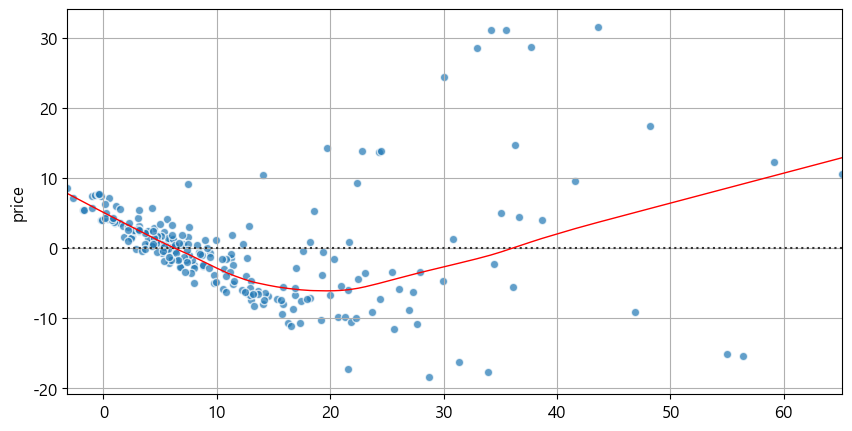


[잔차의 정규성 가정]


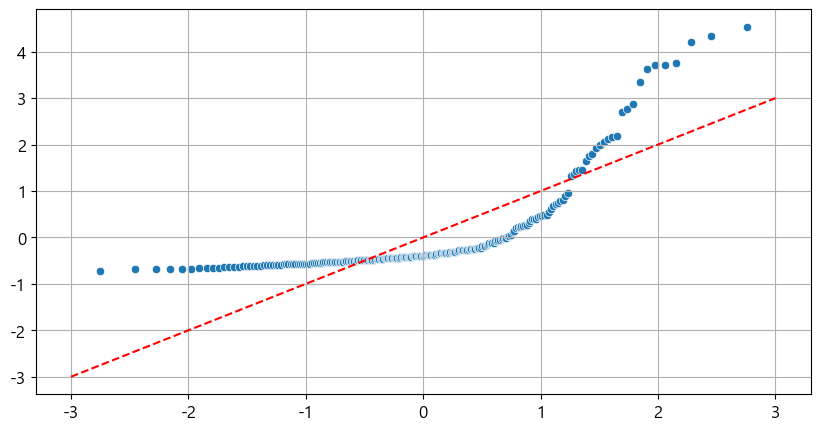

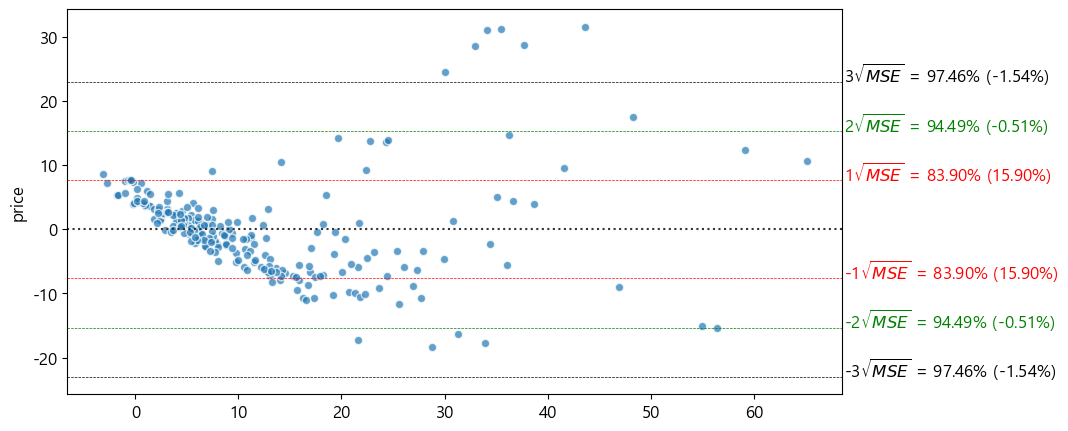

루트 1MSE 구간에 포함된 잔차 비율: 83.90% (15.898305084745758)
루트 2MSE 구간에 포함된 잔차 비율: 94.49% (-0.5084745762711833)
루트 3MSE 구간에 포함된 잔차 비율: 97.46% (-1.5423728813559308)
잔차의 정규성 가정 충족 여부: False

[잔차의 등분산성 가정]
잔차의 등분산성 가정 충족 여부: False
+-----------+-------------+
|           |      values |
|-----------+-------------|
| statistic |     72.7433 |
| p-value   | 2.62346e-06 |
| f-value   |     6.09883 |
| f p-value | 4.41215e-11 |
+-----------+-------------+

[잔차의 독립성 가정]
Durbin-Watson: 2.1133107412151446, 잔차의 독립성 가정 만족 여부: True


In [83]:
final = my_linear_regression(x_train_ignore, y_train, x_test_ignore, y_test, dpi = 100, use_plot = False, report = True, resid_test = True)

In [84]:
from sklearn.linear_model import Ridge, Lasso
rg = Ridge(alpha = 0.1)
la = Lasso(alpha = 0.01)
rg.fit(x_train_ignore, y_train)
la.fit(x_train_ignore, y_train)
rg.score(x_test_ignore, y_test), la.score(x_test_ignore, y_test)

(0.7485764355895577, 0.7490831112352411)

In [95]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
xgb = XGBRegressor(max_depth = 9)
lgbm = LGBMRegressor(max_depth = 11, verbose = -1)
cat = CatBoostRegressor(logging_level = 'Silent')

In [96]:
xgb.fit(x_train_ignore, y_train)
lgbm.fit(x_train_ignore, y_train)
cat.fit(x_train_ignore, y_train)
xgb.score(x_test_ignore, y_test), lgbm.score(x_test_ignore, y_test), cat.score(x_test_ignore, y_test)

(0.8277137357709665, 0.8415859610549262, 0.8544884089182098)

In [87]:
from sklearn.cluster import KMeans

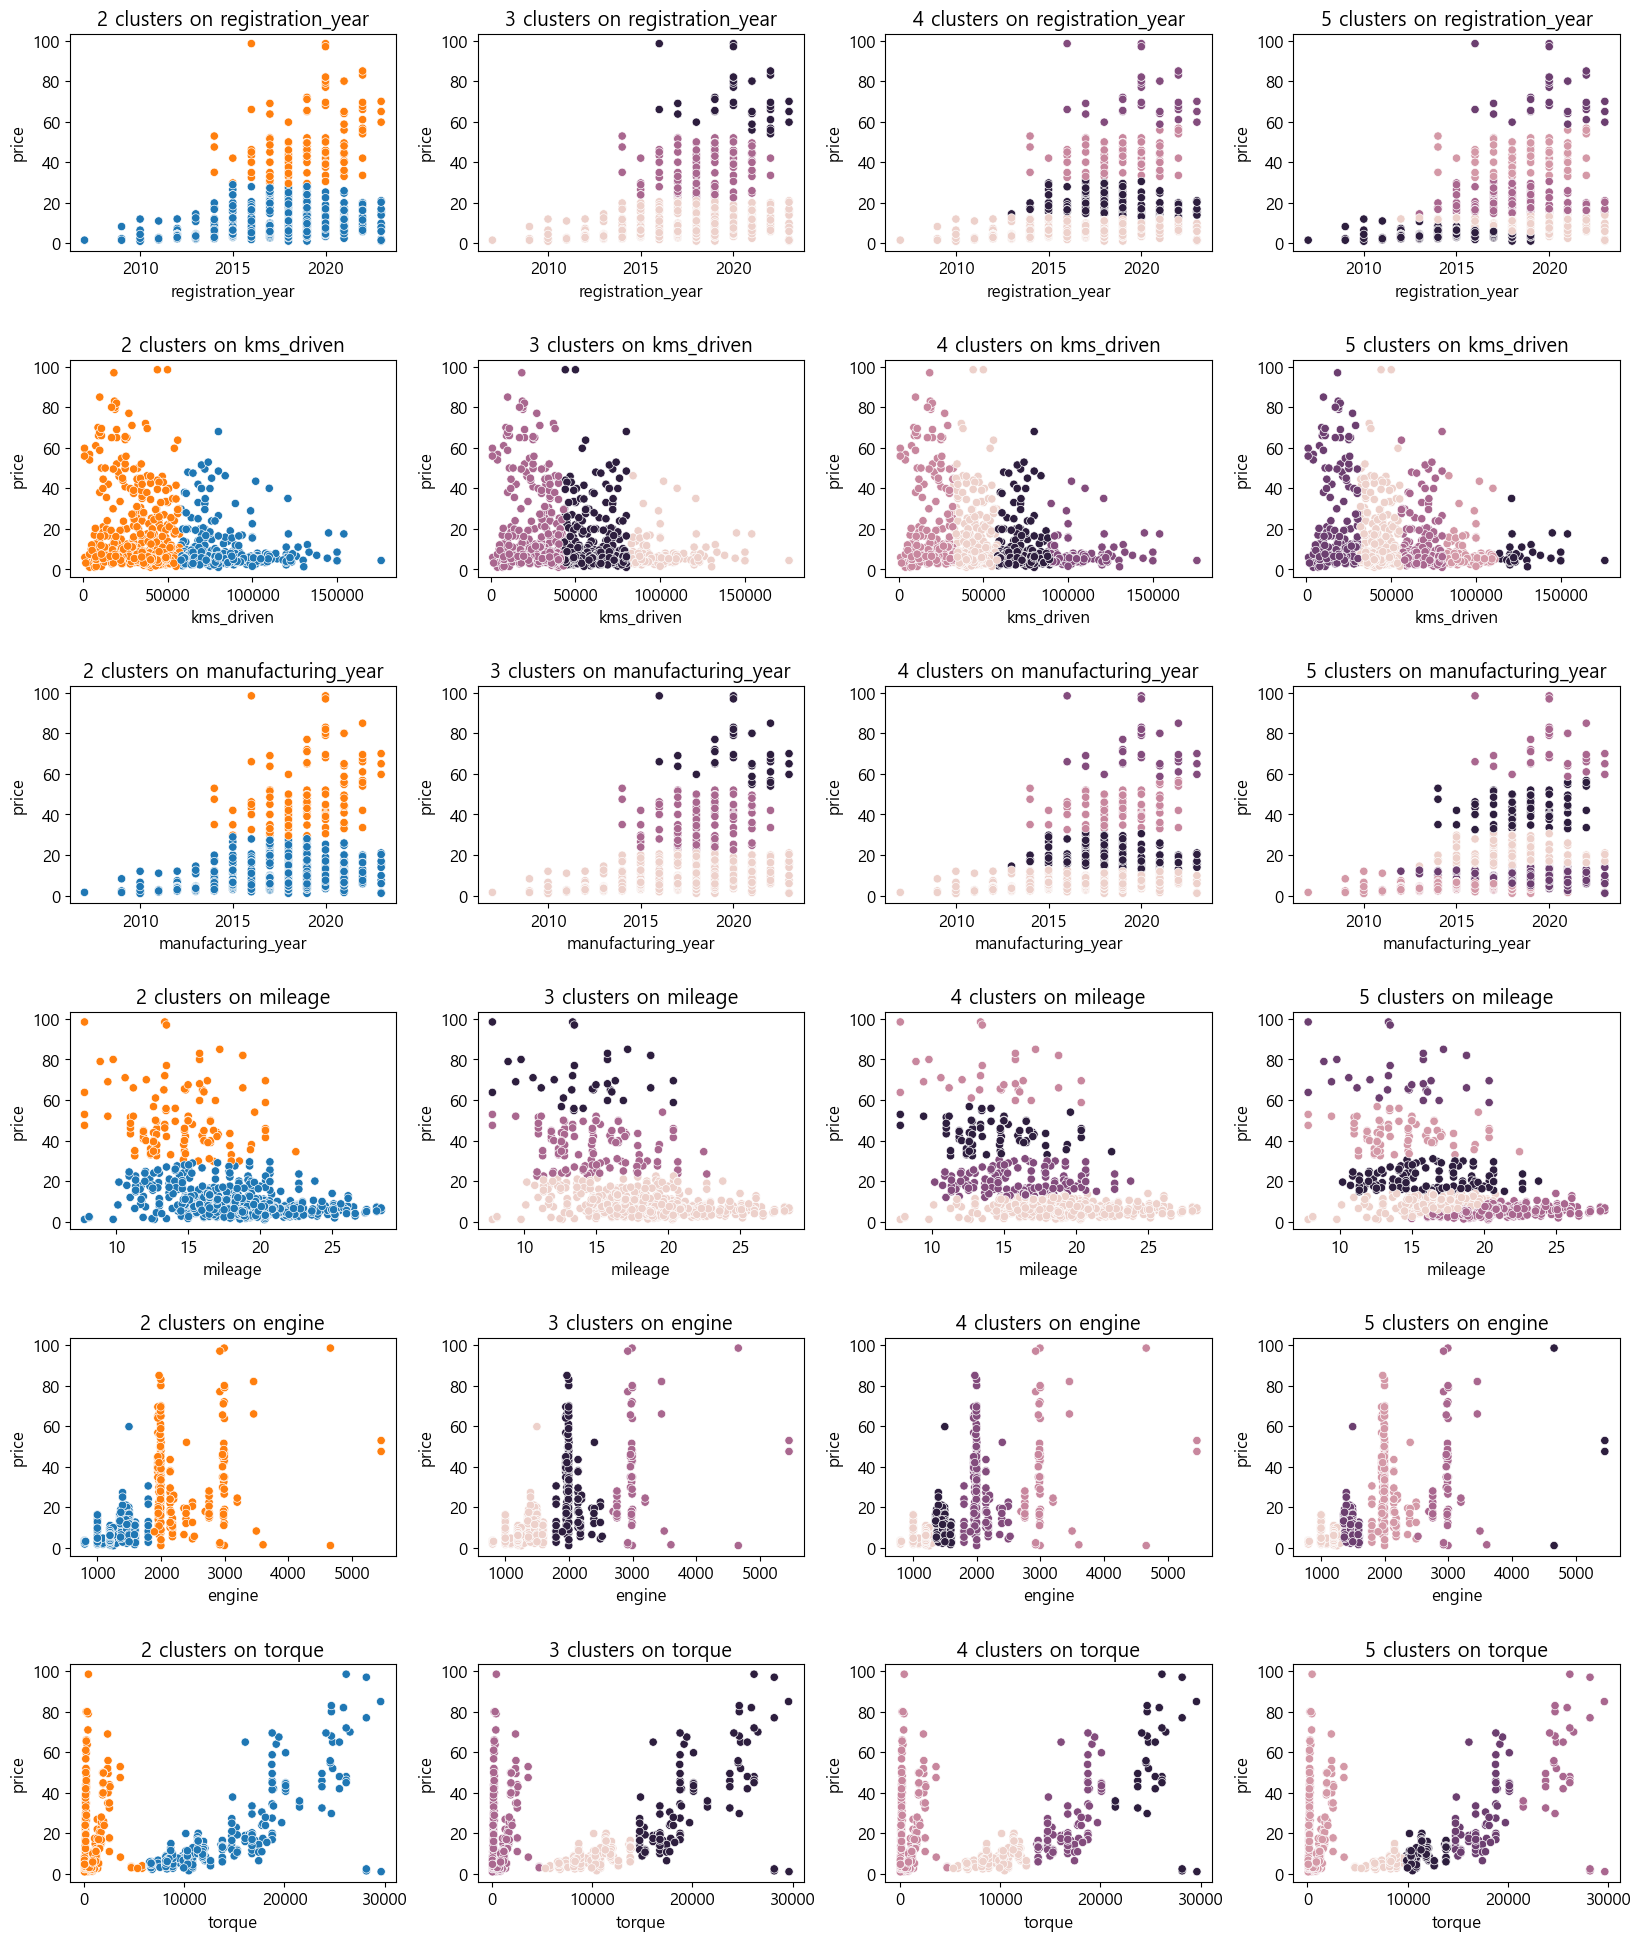

In [88]:
cols = ['registration_year', 'kms_driven', 'manufacturing_year', 'mileage', 'engine', 'torque']
df_log = df.copy()
# df_log['Weekly_Sales'] = np.log(df_log['Weekly_Sales'])

fig, ax = plt.subplots(6, 4, figsize = (20, 24))
fig.subplots_adjust(wspace = 0.25, hspace = 0.5)
for i, v in enumerate(cols):
    tmp = df_log[['price', v]]
    for j in range(2, 6):
        km = KMeans(n_clusters = j, random_state = 0)
        km.fit(tmp)
        tmp2 = pd.concat([tmp, pd.DataFrame(pd.Series(km.labels_, name = 'Cluster'))], axis = 1)
        sb.scatterplot(data = tmp2, x = v, y = 'price', hue = 'Cluster', ax = ax[i, j-2], legend = False)
        ax[i, j-2].set_title(f"{j} clusters on {v}")

plt.show()